In [1]:
import uproot
import matplotlib.pyplot as plt 
import matplotlib as mpl
import mplhep as hep
import numpy as np
import fnmatch
import hist
from tqdm import tqdm
from scipy.signal import find_peaks
import pandas as pd
import os
import sys, importlib

import warnings
warnings.filterwarnings("ignore", category=Warning)

importlib.reload(sys.modules['wc_helper'])
from wc_helper import *

KeyError: 'wc_helper'

In [3]:
# with open("electron_caf.list") as f:
with open("electron_caf_edited.list") as f:
    caf_list = f.read().split('\n')

with open("electron_wvfm.list") as f:
    wvfm_list = f.read().split('\n')
    
# check that we can open all the files 
for i in tqdm(range(len(wvfm_list)-1)):
    if i == 0: continue
    if i == 7: continue
    if i == 8: continue
    # if i == 42: continue
    # if i == 61: continue
    uproot.open(wvfm_list[i])
    uproot.open(caf_list[i])

100%|██████████| 235/235 [00:02<00:00, 100.62it/s]


# Validating Electron Events 

- want to evaluate resolution, bias, and failure rate **without** incorporating "ghost" hits
- want to evaluate "..." on an **event-by-event** basis, not channel by channel. In other words, we want to compare the total sim deposited vs. the total deconvolved deposited (ignoring "ghost" hits)
    - to ignore ghost hits, determine a range of channels to use based on where the majority of ~~deconvolved~~ sim channels are located (deconvolved width is very influenced by ghost hit distribution)
    - could be from low_ch - sigma <-> high_ch + sigma, where sigma is a function of high_ch - low_ch (currently set sigma = 0.1*width)
- which sim channels are valid?

## Read in all events

In [4]:
list_of_df = []
# iterate over files in directory
for filename in os.listdir("./pkl_lowE_event_files/"):
    list_of_df.append(pd.read_pickle("./pkl_lowE_event_files/" +filename))
df = pd.concat(list_of_df)

df = df[df.theta_xz<50]

u_diff_arr = df["u"].to_numpy()
v_diff_arr = df["v"].to_numpy()
w_diff_arr = df["w"].to_numpy()

u_sim_arr = df["u_sim"].to_numpy()
v_sim_arr = df["v_sim"].to_numpy()
w_sim_arr = df["w_sim"].to_numpy()

u_dec_arr = df["u_dec"].to_numpy()
v_dec_arr = df["v_dec"].to_numpy()
w_dec_arr = df["w_dec"].to_numpy()

theta_xz_arr = df["theta_xz"].to_numpy()
depE_arr = df["depE"].to_numpy()

df

,file,sub,tpc,u,v,w,u_sim,v_sim,w_sim,u_dec,v_dec,w_dec,theta_xz,depE
0,223.0,106.0,0.0,-0.342743,-0.130257,-0.018357,13892744.0,13890910.0,13899290.00,10346542.0,12290049.0,13648735.0,43.661690,0.708420
1,223.0,106.0,0.0,-0.126846,-0.149311,-0.027654,6486206.0,6484201.0,6482723.00,5756070.0,5641817.0,6308271.0,22.026825,0.249628
5,223.0,106.0,0.0,-0.342382,-0.321951,-0.025504,34554432.0,34547976.0,34559516.00,25741140.0,26134090.0,33700040.0,24.008945,1.451732
6,223.0,106.0,0.0,-0.142461,0.051993,-0.010359,2014258.5,2013238.0,2012188.75,1763087.0,2123654.0,1991558.0,48.797501,0.076581
7,223.0,106.0,0.0,-0.230160,-0.209112,-0.025685,22311520.0,22299936.0,22310238.00,18137094.0,18443232.0,21751560.0,39.041317,0.893494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,1.0,20.0,1.0,-0.248082,-0.275669,-0.029154,23063540.0,23065774.0,23079616.00,18479180.0,18081312.0,22425812.0,33.982494,1.036492
13,1.0,20.0,1.0,-0.241722,-0.258067,-0.028556,18173876.0,18183556.0,18178732.00,14636024.0,14453568.0,17674036.0,42.046341,0.723276
14,1.0,20.0,1.0,-0.292953,-0.254859,-0.028400,23176688.0,23187708.0,23189952.00,17925386.0,18478340.0,22549540.0,3.831895,1.143965
16,1.0,20.0,1.0,-0.184357,-0.120259,-0.030942,14747625.0,14736528.0,14744152.00,12452005.0,13154568.0,14301626.0,8.777519,0.569531


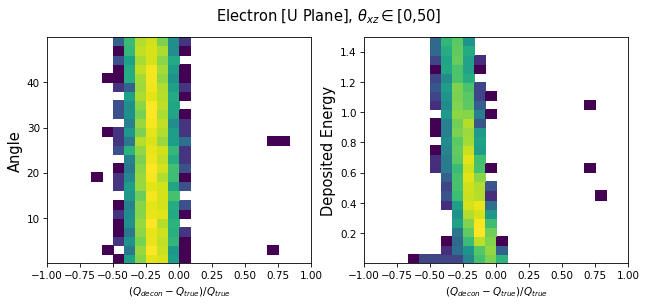

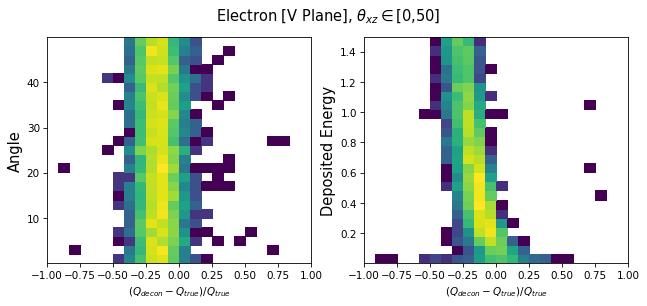

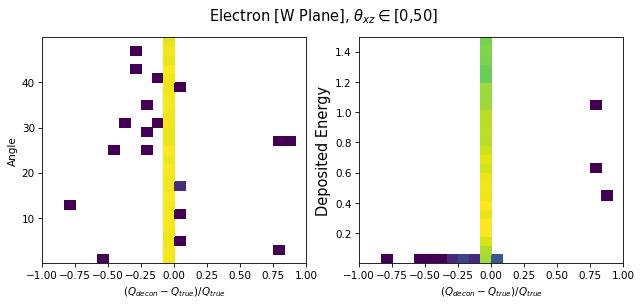

In [4]:
fig, axes = plt.subplots(1,2,figsize=(10,4),dpi=75)
axes[0].hist2d(u_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[1].hist2d(u_diff_arr,depE_arr,    bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[0].set_ylabel("Angle",fontsize=14)
axes[1].set_ylabel("Deposited Energy",fontsize=14)
axes[0].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
axes[1].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")

plt.suptitle(r"Electron [U Plane], $\theta_{xz} \in $[0,50]",fontsize=14)
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,4),dpi=75)
axes[0].hist2d(v_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[1].hist2d(v_diff_arr,depE_arr,    bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[0].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
axes[1].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")

axes[0].set_ylabel("Angle",fontsize=14)
axes[1].set_ylabel("Deposited Energy",fontsize=14)
plt.suptitle(r"Electron [V Plane], $\theta_{xz} \in $[0,50]",fontsize=14)
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,4),dpi=75)
axes[0].hist2d(w_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[1].hist2d(w_diff_arr,depE_arr,    bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[0].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
axes[1].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")

axes[0].set_ylabel("Angle")
axes[1].set_ylabel("Deposited Energy",fontsize=14)
plt.suptitle(r"Electron [W Plane], $\theta_{xz} \in $[0,50]",fontsize=14)
plt.show()

In [229]:
ticks= [0,5,10,20,30,40,50,60,70,80,85]
ticks_prime = np.zeros(len(ticks))
for i, tick in enumerate(ticks):
    ticks_prime[i] = np.round(np.arctan(np.tan(tick*np.pi/180)/np.cos(60*np.pi/180))*180/np.pi)
    
ticklabels = []
for i, angle in enumerate(ticks):
    ticklabels.append(str(int(angle)) + "(" + str(int(ticks_prime[i])) + ")")
energy_bins = np.linspace(0,1.5,11)
englabels = []
for i in energy_bins: 
    englabels.append(str(round(i,2)))

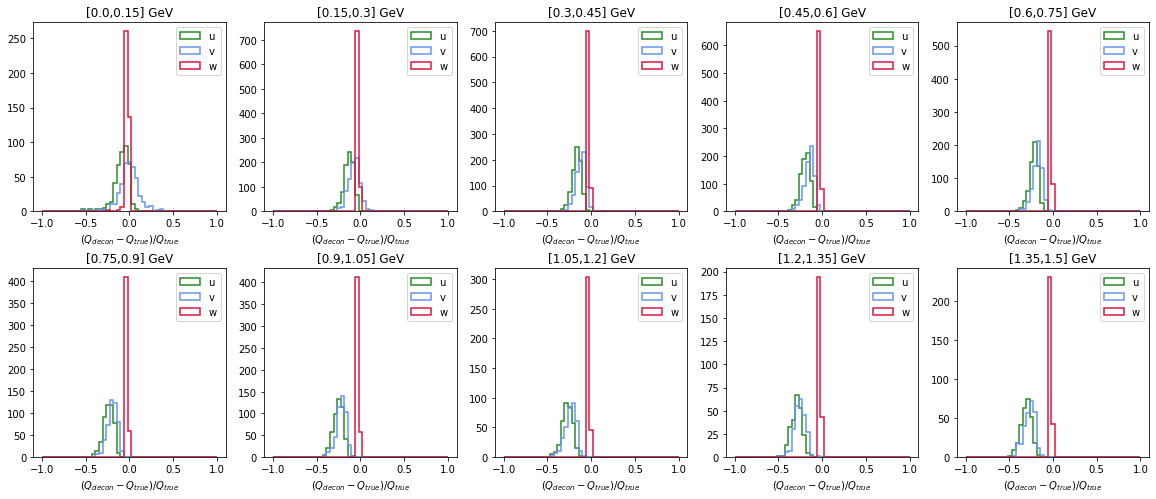

In [231]:
u_med_eng = np.zeros(10); u_std_eng = np.zeros(10)
v_med_eng = np.zeros(10); v_std_eng = np.zeros(10)
w_med_eng = np.zeros(10); w_std_eng = np.zeros(10)

fig, axes = plt.subplots(2,5,figsize=(20,8),sharex=True)
plt.subplots_adjust(hspace=0.3)
for i, ax in enumerate(axes.flatten()):
    lower = energy_bins[i]
    upper = energy_bins[i+1]
    mask = np.where((depE_arr < upper) & (depE_arr >= lower),True,False)  
    u_med_eng[i] = np.ma.median (np.ma.array(u_diff_arr[mask], mask=np.isnan(u_diff_arr[mask]))) 
    u_std_eng[i] = quartile_reso(np.ma.array(u_diff_arr[mask], mask=np.isnan(u_diff_arr[mask]))) 
    v_med_eng[i] = np.ma.median (np.ma.array(v_diff_arr[mask], mask=np.isnan(v_diff_arr[mask]))) 
    v_std_eng[i] = quartile_reso(np.ma.array(v_diff_arr[mask], mask=np.isnan(v_diff_arr[mask]))) 
    w_med_eng[i] = np.ma.median (np.ma.array(w_diff_arr[mask], mask=np.isnan(w_diff_arr[mask]))) 
    w_std_eng[i] = quartile_reso(np.ma.array(w_diff_arr[mask], mask=np.isnan(w_diff_arr[mask]))) 
    
    ax.hist(u_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="u",color="forestgreen")
    ax.hist(v_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="v",color="cornflowerblue")
    ax.hist(w_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="w",color="crimson")
    ax.tick_params(labelbottom=True)
    ax.legend()
    ax.set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
    ax.set_title(fr"[{round(lower,3)},{round(upper,3)}] GeV")
plt.show()
    

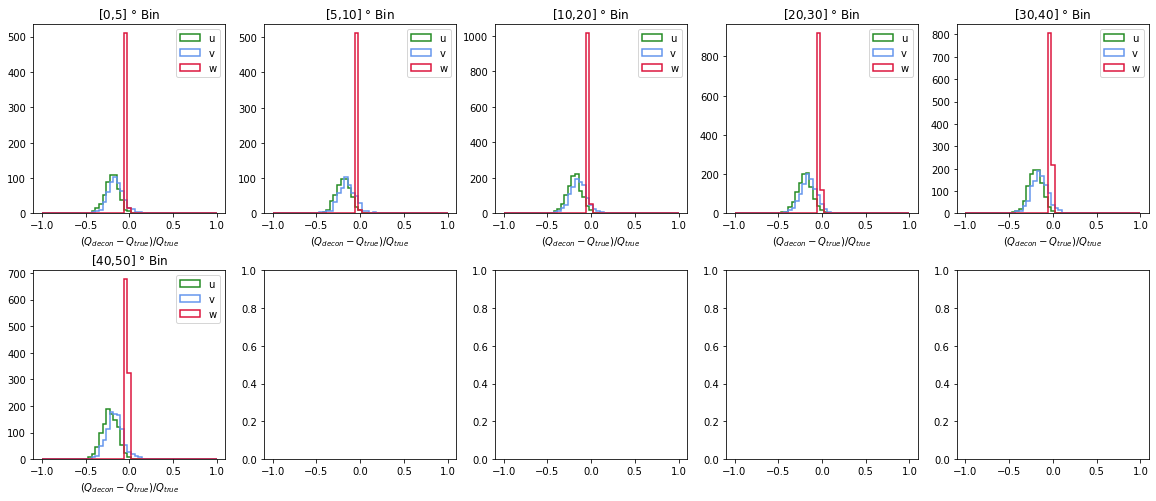

In [232]:
u_med_ang = np.zeros(10); u_std_ang = np.zeros(10)
v_med_ang = np.zeros(10); v_std_ang = np.zeros(10)
w_med_ang = np.zeros(10); w_std_ang = np.zeros(10)

fig, axes = plt.subplots(2,5,figsize=(20,8),sharex=True)
plt.subplots_adjust(hspace=0.3)
for i, ax in enumerate(axes.flatten()):
    lower = ticks[i]
    upper = ticks[i+1]
    mask = np.where((theta_xz_arr < upper) & (theta_xz_arr >= lower),True,False)
    if mask.sum() == 0: continue
    u_med_ang[i] = np.ma.median (np.ma.array(u_diff_arr[mask], mask=np.isnan(u_diff_arr[mask]))) 
    u_std_ang[i] = quartile_reso(np.ma.array(u_diff_arr[mask], mask=np.isnan(u_diff_arr[mask]))) 
    v_med_ang[i] = np.ma.median (np.ma.array(v_diff_arr[mask], mask=np.isnan(v_diff_arr[mask]))) 
    v_std_ang[i] = quartile_reso(np.ma.array(v_diff_arr[mask], mask=np.isnan(v_diff_arr[mask]))) 
    w_med_ang[i] = np.ma.median (np.ma.array(w_diff_arr[mask], mask=np.isnan(w_diff_arr[mask]))) 
    w_std_ang[i] = quartile_reso(np.ma.array(w_diff_arr[mask], mask=np.isnan(w_diff_arr[mask]))) 
    
    ax.hist(u_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="u",color="forestgreen")
    ax.hist(v_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="v",color="cornflowerblue")
    ax.hist(w_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="w",color="crimson")
    ax.tick_params(labelbottom=True)
    ax.legend()
    ax.set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
    ax.set_title(fr"[{lower},{upper}] $\degree$ Bin")
    # plt.yscale("log")
plt.show()
    

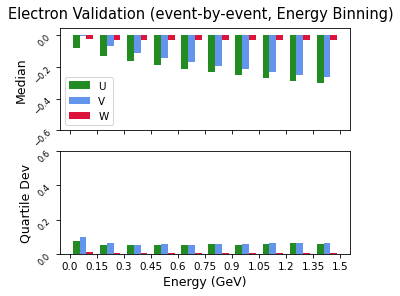

In [233]:
fig, axes = plt.subplots(2,1,figsize=(5,4),sharex=True,dpi=75)
# plt.subplots_adjust(hspace=0.08)
N=10
width = 0.25
# ticklabels = ["0","5","10","20","30","40","50","60","70","80","85"]
axes[0].set_xticks(np.arange(N+1)-0.5)
axes[0].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[0].bar(np.arange(N)-width, u_med_eng,width=width,label="U",color="forestgreen")
axes[0].bar(np.arange(N)      , v_med_eng,width=width,label="V",color="cornflowerblue")
axes[0].bar(np.arange(N)+width, w_med_eng,width=width,label="W",color="crimson")
axes[0].set_ylabel("Median",fontsize=12)
axes[0].legend()
axes[0].set_ylim(-0.60,0.05)

axes[1].bar(np.arange(N)-width,u_std_eng,width=width,label="U",color="forestgreen")
axes[1].bar(np.arange(N),      v_std_eng,width=width,label="V",color="cornflowerblue")
axes[1].bar(np.arange(N)+width,w_std_eng,width=width,label="W",color="crimson")
axes[1].set_ylabel("Quartile Dev",fontsize=12)
axes[1].tick_params(labelbottom=True)
axes[1].set_yticks([0.0,0.2,0.4,0.6])
axes[1].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[1].set_ylim(0,0.6)
axes[1].set_xticklabels(englabels)
axes[1].set_xlabel("Energy (GeV)",fontsize=12)

plt.suptitle("Electron Validation (event-by-event, Energy Binning)",fontsize=14,y=0.95)
plt.show()

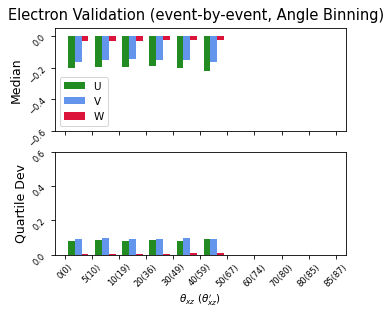

In [112]:
fig, axes = plt.subplots(2,1,figsize=(5,4),sharex=True,dpi=75)
# plt.subplots_adjust(hspace=0.08)
N=10
width = 0.25
axes[0].set_xticks(np.arange(N+1)-0.5)
axes[0].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[0].bar(np.arange(N)-width, u_med_ang,width=width,label="U",color="forestgreen")
axes[0].bar(np.arange(N)      , v_med_ang,width=width,label="V",color="cornflowerblue")
axes[0].bar(np.arange(N)+width, w_med_ang,width=width,label="W",color="crimson")
axes[0].set_ylabel("Median",fontsize=12)
axes[0].legend()
axes[0].set_ylim(-0.60,0.05)

axes[1].bar(np.arange(N)-width,u_std_ang,width=width,label="U",color="forestgreen")
axes[1].bar(np.arange(N),      v_std_ang,width=width,label="V",color="cornflowerblue")
axes[1].bar(np.arange(N)+width,w_std_ang,width=width,label="W",color="crimson")
axes[1].set_ylabel("Quartile Dev",fontsize=12)
axes[1].tick_params(labelbottom=True)
axes[1].set_yticks([0.0,0.2,0.4,0.6])
axes[1].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[1].set_ylim(0,0.6)
axes[1].set_xticklabels(ticklabels)
axes[1].xaxis.set_tick_params(labelsize=8,rotation=45)
axes[1].set_xlabel(r"$\theta_{xz}$ ($\theta_{xz}'$)")

plt.suptitle("Electron Validation (event-by-event, Angle Binning)",fontsize=14,y=0.95)
plt.show()

## test with a single event

In [119]:
for idx in range(1):
    N = 20 # number of events
    file_idx = 7
    
    file_arr =  np.zeros(shape=(N,2)); subrun_arr = np.zeros(shape=(N,2)); tpc_arr =    np.zeros(shape=(N,2))
    u_diff_arr =np.zeros(shape=(N,2)); v_diff_arr = np.zeros(shape=(N,2)); w_diff_arr = np.zeros(shape=(N,2))
    u_sim_arr = np.zeros(shape=(N,2)); v_sim_arr =  np.zeros(shape=(N,2)); w_sim_arr =  np.zeros(shape=(N,2))
    u_dec_arr = np.zeros(shape=(N,2)); v_dec_arr =  np.zeros(shape=(N,2)); w_dec_arr =  np.zeros(shape=(N,2)) 
    theta_arr = np.zeros(shape=(N,2)); depE_arr =   np.zeros(shape=(N,2))
    
    wvfm = uproot.open(wvfm_list[file_idx])
    dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
    sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
    raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')
    caf = uproot.open(caf_list[file_idx]+":recTree")
    tree = caf.arrays(["rec.hdr.run","rec.hdr.subrun","rec.hdr.evt",
                    "rec.mc.nu.prim.startp.x" ,"rec.mc.nu.prim.startp.y","rec.mc.nu.prim.startp.z",
                    "rec.mc.nu.prim.startE","rec.mc.nu.prim.endE"],library='pd')

    tree["theta_xz"] = np.arctan(abs(tree["rec.mc.nu.prim.startp.x"]/tree["rec.mc.nu.prim.startp.z"]))*(180/np.pi)
    tree["depE"] =  tree["rec.mc.nu.prim.startE"] - tree["rec.mc.nu.prim.endE"]
    tree["tpc"] = np.where(tree["rec.mc.nu.prim.startp.x"]>0,1,0)
    subrun = tree.iloc[0]["rec.hdr.subrun"]
    for event in range(len(dec_names)):
        evt_sim = wvfm[sim_names[event]].values()
        evt_dec = wvfm[dec_names[event]].values()*50
        
        for tpc in range(2):
            this_tree = tree[tree.tpc==0] if tpc == 0 else tree[tree.tpc==1]
            u_sim = u0_ch(evt_sim) if tpc == 0 else u1_ch(evt_sim); u_dec = u0_ch(evt_dec) if tpc == 0 else u1_ch(evt_dec)
            v_sim = v0_ch(evt_sim) if tpc == 0 else v1_ch(evt_sim); v_dec = v0_ch(evt_dec) if tpc == 0 else v1_ch(evt_dec)
            w_sim = w0_ch(evt_sim) if tpc == 0 else w1_ch(evt_sim); w_dec = w0_ch(evt_dec) if tpc == 0 else w1_ch(evt_dec)
            
            u_sim_sum = np.sum(u_sim, axis=1); v_sim_sum = np.sum(v_sim, axis=1); w_sim_sum = np.sum(w_sim, axis=1)
            u_dec_sum = np.sum(u_dec, axis=1); v_dec_sum = np.sum(v_dec, axis=1); w_dec_sum = np.sum(w_dec, axis=1)
            
            u_sim_bool = pass_sim(u_sim); v_sim_bool = pass_sim(v_sim); w_sim_bool = pass_sim(w_sim)
            u_sim_pass = np.where( u_sim_bool)[0]; v_sim_pass = np.where( v_sim_bool)[0]; w_sim_pass = np.where( w_sim_bool)[0]

            u_ch_width = np.max(u_sim_pass) - np.min(u_sim_pass); v_ch_width = np.max(v_sim_pass) - np.min(v_sim_pass); w_ch_width = np.max(w_sim_pass) - np.min(w_sim_pass)            
            u_ch_sigma = round(u_ch_width*0.1); v_ch_sigma = round(v_ch_width*0.1); w_ch_sigma = round(w_ch_width*0.1)
            
            u_ch_min = np.min(u_sim_pass) - u_ch_sigma; u_ch_max = np.max(u_sim_pass) + u_ch_sigma
            v_ch_min = np.min(v_sim_pass) - v_ch_sigma; v_ch_max = np.max(v_sim_pass) + v_ch_sigma
            w_ch_min = np.min(w_sim_pass) - w_ch_sigma; w_ch_max = np.max(w_sim_pass) + w_ch_sigma
            
            # the sum we use for dec over the entire event is corrected by only using channels that wouldn't have ghosts in them
            u_dec_evt = np.sum(u_dec_sum[u_ch_min:u_ch_max]); v_dec_evt = np.sum(v_dec_sum[v_ch_min:v_ch_max]); w_dec_evt = np.sum(w_dec_sum[w_ch_min:w_ch_max])
            
            # the sum we use for sim over the entire event should not include sim channels that do not pass 
            u_sim_evt = np.sum(u_sim_sum[u_sim_bool]); v_sim_evt = np.sum(v_sim_sum[v_sim_bool]); w_sim_evt = np.sum(w_sim_sum[w_sim_bool])
            
            u_diff_arr[event][tpc] = (u_dec_evt - u_sim_evt)/u_dec_evt
            v_diff_arr[event][tpc] = (v_dec_evt - v_sim_evt)/v_dec_evt
            w_diff_arr[event][tpc] = (w_dec_evt - w_sim_evt)/w_dec_evt
            u_sim_arr[event][tpc] = u_sim_evt; v_sim_arr[event][tpc] = v_sim_evt; w_sim_arr[event][tpc] = w_sim_evt
            u_dec_arr[event][tpc] = u_dec_evt; v_dec_arr[event][tpc] = v_dec_evt; w_dec_arr[event][tpc] = w_dec_evt
            theta_arr[event][tpc]  = this_tree.iloc[event]["theta_xz"]
            depE_arr[event][tpc]   = this_tree.iloc[event]["depE"]
            tpc_arr[event][tpc]    = tpc
            file_arr[event][tpc]   = file_idx
            subrun_arr[event][tpc] = subrun

    df0 = pd.DataFrame({'file' : file_arr[:,0], 'sub' : subrun_arr[:,0], 'tpc' : tpc_arr[:,0],'u': u_diff_arr[:,0], 'v': v_diff_arr[:,0], 'w': w_diff_arr[:,0],
                        'u_sim' : u_sim_arr[:,0], 'v_sim' : v_sim_arr[:,0], 'w_sim' : w_sim_arr[:,0],
                        'u_dec' : u_dec_arr[:,0], 'v_dec' : v_dec_arr[:,0], 'w_dec' : w_dec_arr[:,0],
                        "theta_xz" : theta_arr[:,0], 'depE' : depE_arr[:,0]})
    df1 = pd.DataFrame({'file' : file_arr[:,1], 'sub' : subrun_arr[:,1], 'tpc' : tpc_arr[:,1],'u': u_diff_arr[:,1], 'v': v_diff_arr[:,1], 'w': w_diff_arr[:,1],
                        'u_sim' : u_sim_arr[:,1], 'v_sim' : v_sim_arr[:,1], 'w_sim' : w_sim_arr[:,1],
                        'u_dec' : u_dec_arr[:,1], 'v_dec' : v_dec_arr[:,1], 'w_dec' : w_dec_arr[:,1],
                        "theta_xz" : theta_arr[:,1], 'depE' : depE_arr[:,1]})
    df = pd.concat([df0,df1])

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in float_scalars
/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in float_scalars


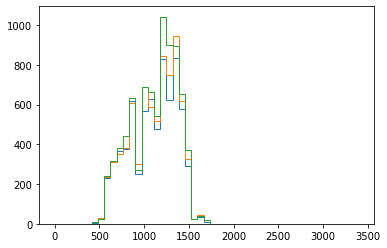

417 1707
417 1707
417 1707


In [208]:
evtnum = 18
evt_sim = wvfm[sim_names[evtnum]].values()
evt_dec = wvfm[dec_names[evtnum]].values()*50

sim_ch_sum = np.sum(evt_sim,axis=1)
dec_ch_sum = np.sum(evt_dec,axis=1)

# print("fractional total diff (all ch): ", np.sum(dec_ch_sum-sim_ch_sum)/np.sum(sim_ch_sum))
# print("fractional diff (u0 plane): ", np.sum(u0_ch(dec_ch_sum)-u0_ch(sim_ch_sum))/np.sum(u0_ch(sim_ch_sum)))
# print("fractional diff (v0 plane): ", np.sum(v0_ch(dec_ch_sum)-v0_ch(sim_ch_sum))/np.sum(v0_ch(sim_ch_sum)))
# print("fractional diff (w0 plane): ", np.sum(w0_ch(dec_ch_sum)-w0_ch(sim_ch_sum))/np.sum(w0_ch(sim_ch_sum)))
# print("fractional diff (u1 plane): ", np.sum(u1_ch(dec_ch_sum)-u1_ch(sim_ch_sum))/np.sum(u1_ch(sim_ch_sum)))
# print("fractional diff (v1 plane): ", np.sum(v1_ch(dec_ch_sum)-v1_ch(sim_ch_sum))/np.sum(v1_ch(sim_ch_sum)))
# print("fractional diff (w1 plane): ", np.sum(w1_ch(dec_ch_sum)-w1_ch(sim_ch_sum))/np.sum(w1_ch(sim_ch_sum)))

u_ch_pass = u0_ch(evt_sim)[pass_sim(u0_ch(evt_sim))]
v_ch_pass = v0_ch(evt_sim)[pass_sim(v0_ch(evt_sim))]
w_ch_pass = w0_ch(evt_sim)[pass_sim(w0_ch(evt_sim))]
u_row, u_col = np.nonzero(u_ch_pass); v_row, v_col = np.nonzero(v_ch_pass); w_row, w_col = np.nonzero(w_ch_pass)
plt.hist(u_col,histtype="step",bins=np.linspace(0,3400,50))
plt.hist(v_col,histtype="step",bins=np.linspace(0,3400,50))
plt.hist(w_col,histtype="step",bins=np.linspace(0,3400,50))
plt.show()

print(np.min(u_col),np.max(u_col))
print(np.min(v_col),np.max(v_col))
print(np.min(w_col),np.max(w_col))

In [180]:
decon_ch = np.where((dec_ch_sum>1))[0]
simul_ch = np.where(pass_sim(evt_sim))[0]

u0_ch_width = np.max(simul_ch[simul_ch<idx_v0]) - np.min(simul_ch[simul_ch<idx_v0])
u0_ch_sigma = round(u0_ch_width*0.1)
u0_ch_min = np.min(simul_ch[simul_ch<idx_v0]) - u0_ch_sigma
u0_ch_max = np.max(simul_ch[simul_ch<idx_v0]) + u0_ch_sigma

v0_ch_width = np.max(simul_ch[(simul_ch>idx_v0) & (simul_ch<idx_w0)]) - np.min(simul_ch[(simul_ch>idx_v0) & (simul_ch<idx_w0)])
v0_ch_sigma = round(v0_ch_width*0.1)
v0_ch_min = np.min(simul_ch[(simul_ch>idx_v0) & (simul_ch<idx_w0)]) - v0_ch_sigma
v0_ch_max = np.max(simul_ch[(simul_ch>idx_v0) & (simul_ch<idx_w0)]) + v0_ch_sigma

w0_ch_width = np.max(simul_ch[(simul_ch>idx_w0) & (simul_ch<idx_u1)]) - np.min(simul_ch[(simul_ch>idx_w0) & (simul_ch<idx_u1)])
w0_ch_sigma = round(w0_ch_width*0.1)
w0_ch_min = np.min(simul_ch[(simul_ch>idx_w0) & (simul_ch<idx_u1)]) - w0_ch_sigma
w0_ch_max = np.max(simul_ch[(simul_ch>idx_w0) & (simul_ch<idx_u1)]) + w0_ch_sigma

u1_ch_width = np.max(simul_ch[(simul_ch>idx_u1) & (simul_ch<idx_v1)]) - np.min(simul_ch[(simul_ch>idx_u1) & (simul_ch<idx_v1)])
u1_ch_sigma = round(u1_ch_width*0.1)
u1_ch_min = np.min(simul_ch[(simul_ch>idx_u1) & (simul_ch<idx_v1)]) - u1_ch_sigma
u1_ch_max = np.max(simul_ch[(simul_ch>idx_u1) & (simul_ch<idx_v1)]) + u1_ch_sigma

v1_ch_width = np.max(simul_ch[(simul_ch>idx_v1) & (simul_ch<idx_w1)]) - np.min(simul_ch[(simul_ch>idx_v1) & (simul_ch<idx_w1)])
v1_ch_sigma = round(v1_ch_width*0.1)
v1_ch_min = np.min(simul_ch[(simul_ch>idx_v1) & (simul_ch<idx_w1)]) - v1_ch_sigma
v1_ch_max = np.max(simul_ch[(simul_ch>idx_v1) & (simul_ch<idx_w1)]) + v1_ch_sigma

w1_ch_width = np.max(simul_ch[(simul_ch>idx_w1)]) - np.min(simul_ch[(simul_ch>idx_w1)])
w1_ch_sigma = round(w1_ch_width*0.1)
w1_ch_min = np.min(simul_ch[(simul_ch>idx_w1)]) - w1_ch_sigma
w1_ch_max = np.max(simul_ch[(simul_ch>idx_w1)]) + w1_ch_sigma

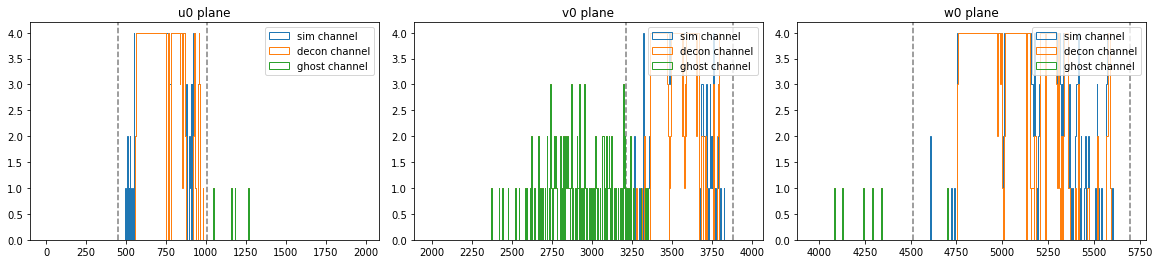

In [22]:
fig, axes = plt.subplots(1,3,figsize=(20,4))
plt.subplots_adjust(wspace=0.1)

axes[0].hist(simul_ch,range=[0,idx_v0],histtype='step',bins=int((idx_v0-0)/4),label="sim channel")
axes[0].hist(decon_ch,range=[0,idx_v0],histtype='step',bins=int((idx_v0-0)/4),label="decon channel")
axes[0].hist(ghost_ch,range=[0,idx_v0],histtype='step',bins=int((idx_v0-0)/4),label="ghost channel")
ymin,ymax = axes[0].get_ylim()
axes[0].vlines(u0_ch_min,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[0].vlines(u0_ch_max,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[0].set_ylim(ymin,ymax)

axes[1].hist(simul_ch,range=[idx_v0,idx_w0],histtype='step',bins=int((idx_w0-idx_v0)/4),label="sim channel")
axes[1].hist(decon_ch,range=[idx_v0,idx_w0],histtype='step',bins=int((idx_w0-idx_v0)/4),label="decon channel")
axes[1].hist(ghost_ch,range=[idx_v0,idx_w0],histtype='step',bins=int((idx_w0-idx_v0)/4),label="ghost channel")
ymin,ymax = axes[1].get_ylim()
axes[1].vlines(v0_ch_min,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[1].vlines(v0_ch_max,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[1].set_ylim(ymin,ymax)

axes[2].hist(simul_ch,range=[idx_w0,idx_u1],histtype='step',bins=int((idx_u1-idx_w0)/4),label="sim channel")
axes[2].hist(decon_ch,range=[idx_w0,idx_u1],histtype='step',bins=int((idx_u1-idx_w0)/4),label="decon channel")
axes[2].hist(ghost_ch,range=[idx_w0,idx_u1],histtype='step',bins=int((idx_u1-idx_w0)/4),label="ghost channel")
ymin,ymax = axes[2].get_ylim()
axes[2].vlines(w0_ch_min,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[2].vlines(w0_ch_max,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[2].set_ylim(ymin,ymax)

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_title("u0 plane")
axes[1].set_title("v0 plane")
axes[2].set_title("w0 plane")

plt.show()

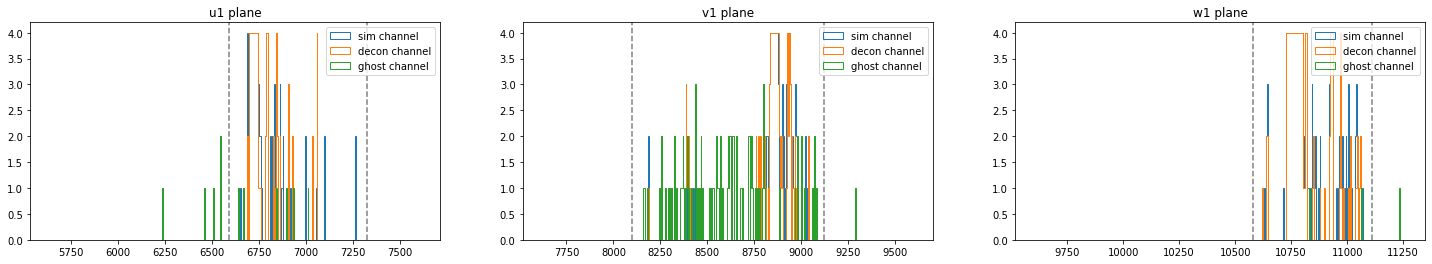

In [23]:
fig, axes = plt.subplots(1,3,figsize=(25,4))

axes[0].hist(simul_ch,range=[idx_u1,idx_v1],histtype='step',bins=int((idx_v1-idx_u1)/4),label="sim channel")
axes[0].hist(decon_ch,range=[idx_u1,idx_v1],histtype='step',bins=int((idx_v1-idx_u1)/4),label="decon channel")
axes[0].hist(ghost_ch,range=[idx_u1,idx_v1],histtype='step',bins=int((idx_v1-idx_u1)/4),label="ghost channel")
ymin,ymax = axes[0].get_ylim()
axes[0].vlines(u1_ch_min,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[0].vlines(u1_ch_max,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[0].set_ylim(ymin,ymax)

axes[1].hist(simul_ch,range=[idx_v1,idx_w1],histtype='step',bins=int((idx_w1-idx_v1)/4),label="sim channel")
axes[1].hist(decon_ch,range=[idx_v1,idx_w1],histtype='step',bins=int((idx_w1-idx_v1)/4),label="decon channel")
axes[1].hist(ghost_ch,range=[idx_v1,idx_w1],histtype='step',bins=int((idx_w1-idx_v1)/4),label="ghost channel")
ymin,ymax = axes[1].get_ylim()
axes[1].vlines(v1_ch_min,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[1].vlines(v1_ch_max,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[1].set_ylim(ymin,ymax)

axes[2].hist(simul_ch,range=[idx_w1,11265],histtype='step',bins=int((11265-idx_w1)/4),label="sim channel")
axes[2].hist(decon_ch,range=[idx_w1,11265],histtype='step',bins=int((11265-idx_w1)/4),label="decon channel")
axes[2].hist(ghost_ch,range=[idx_w1,11265],histtype='step',bins=int((11265-idx_w1)/4),label="ghost channel")
ymin,ymax = axes[2].get_ylim()
axes[2].vlines(w1_ch_min,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[2].vlines(w1_ch_max,ymin=ymin, ymax=ymax,linestyles='dashed',colors='gray')
axes[2].set_ylim(ymin,ymax)

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_title("u1 plane")
axes[1].set_title("v1 plane")
axes[2].set_title("w1 plane")

plt.show()

In [76]:
print("u0 fractional diff (after ghost removal): ", np.sum(dec_ch_sum[u0_ch_min:u0_ch_max]-sim_ch_sum[u0_ch_min:u0_ch_max])/np.sum(sim_ch_sum[u0_ch_min:u0_ch_max]))
print("v0 fractional diff (after ghost removal): ", np.sum(dec_ch_sum[v0_ch_min:v0_ch_max]-sim_ch_sum[v0_ch_min:v0_ch_max])/np.sum(sim_ch_sum[v0_ch_min:v0_ch_max]))
print("w0 fractional diff (after ghost removal): ", np.sum(dec_ch_sum[w0_ch_min:w0_ch_max]-sim_ch_sum[w0_ch_min:w0_ch_max])/np.sum(sim_ch_sum[w0_ch_min:w0_ch_max]))

print("u1 fractional diff (after ghost removal): ", np.sum(dec_ch_sum[u1_ch_min:u1_ch_max]-sim_ch_sum[u1_ch_min:u1_ch_max])/np.sum(sim_ch_sum[u1_ch_min:u1_ch_max]))
print("v1 fractional diff (after ghost removal): ", np.sum(dec_ch_sum[v1_ch_min:v1_ch_max]-sim_ch_sum[v1_ch_min:v1_ch_max])/np.sum(sim_ch_sum[v1_ch_min:v1_ch_max]))
print("w1 fractional diff (after ghost removal): ", np.sum(dec_ch_sum[w1_ch_min:w1_ch_max]-sim_ch_sum[w1_ch_min:w1_ch_max])/np.sum(sim_ch_sum[w1_ch_min:w1_ch_max]))

u0 fractional diff (after ghost removal):  -0.18886785
v0 fractional diff (after ghost removal):  -0.17700246
w0 fractional diff (after ghost removal):  -0.031568162
u1 fractional diff (after ghost removal):  -0.21062967
v1 fractional diff (after ghost removal):  -0.14188665
w1 fractional diff (after ghost removal):  -0.016420504


In [92]:
np.shape(np.where(pass_sim(evt_sim),sim_ch_sum,0))

(11265,)

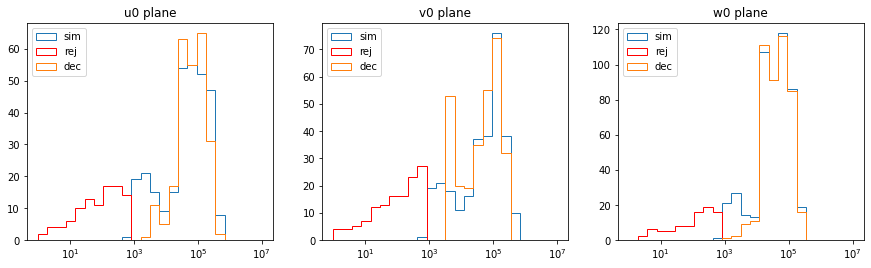

In [100]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
bins=np.logspace(0,7,25)
axes[0].hist(u0_ch(np.where( pass_sim(evt_sim),sim_ch_sum,0)),histtype='step',bins=bins,label="sim")
axes[0].hist(u0_ch(np.where(~pass_sim(evt_sim),sim_ch_sum,0)),histtype='step',bins=bins,label="rej",color="red")
axes[0].hist(dec_ch_sum[u0_ch_min:u0_ch_max],histtype='step',bins=bins,label="dec")

axes[1].hist(v0_ch(np.where(pass_sim(evt_sim),sim_ch_sum,0)),histtype='step',bins=bins,label="sim")
axes[1].hist(v0_ch(np.where(~pass_sim(evt_sim),sim_ch_sum,0)),histtype='step',bins=bins,label="rej",color="red")
axes[1].hist(dec_ch_sum[v0_ch_min:v0_ch_max],histtype='step',bins=bins,label="dec")

axes[2].hist(w0_ch(np.where(pass_sim(evt_sim),sim_ch_sum,0)),histtype='step',bins=bins,label="sim")
axes[2].hist(w0_ch(np.where(~pass_sim(evt_sim),sim_ch_sum,0)),histtype='step',bins=bins,label="rej",color="red")
axes[2].hist(dec_ch_sum[w0_ch_min:w0_ch_max],histtype='step',bins=bins,label="dec")

axes[0].set_xscale('log'); axes[1].set_xscale('log'); axes[2].set_xscale('log')
axes[0].set_title("u0 plane"); axes[1].set_title("v0 plane"); axes[2].set_title("w0 plane")
axes[0].legend(loc="upper left"); axes[1].legend(loc="upper left"); axes[2].legend(loc="upper left")

plt.show()

## Distribution of large/small hits/channels binned by energy
- want to know, for a given energy bin, what are the percentages of channels with non-zero (sim or decon) wvfms? 

In [20]:
N=20
u_sim_sum_arr = np.zeros((N*2,idx_v0)); v_sim_sum_arr = np.zeros((N*2,idx_w0-idx_v0)); w_sim_sum_arr = np.zeros((N*2,idx_u1-idx_w0))
u_rej_sum_arr = np.zeros((N*2,idx_v0)); v_rej_sum_arr = np.zeros((N*2,idx_w0-idx_v0)); w_rej_sum_arr = np.zeros((N*2,idx_u1-idx_w0))
u_dec_sum_arr = np.zeros((N*2,idx_v0)); v_dec_sum_arr = np.zeros((N*2,idx_w0-idx_v0)); w_dec_sum_arr = np.zeros((N*2,idx_u1-idx_w0))
u_gho_sum_arr = np.zeros((N*2,idx_v0)); v_gho_sum_arr = np.zeros((N*2,idx_w0-idx_v0)); w_gho_sum_arr = np.zeros((N*2,idx_u1-idx_w0))
theta_xz_sum_arr = np.zeros(N*2); depE_sum_arr = np.zeros(N*2)

# iterate over files in directory
for filename in tqdm(os.listdir("./npz_files/")):
    if filename.startswith('.'): continue
    file = np.load("./npz_files/"+filename,allow_pickle=True)
    u_sim_sum_arr = np.concatenate((file["u_sim_sum_arr"],u_sim_sum_arr))
    v_sim_sum_arr = np.concatenate((file["v_sim_sum_arr"],v_sim_sum_arr))
    w_sim_sum_arr = np.concatenate((file["w_sim_sum_arr"],w_sim_sum_arr))
    u_rej_sum_arr = np.concatenate((file["u_sim_rej_arr"],u_rej_sum_arr))
    v_rej_sum_arr = np.concatenate((file["v_sim_rej_arr"],v_rej_sum_arr))
    w_rej_sum_arr = np.concatenate((file["w_sim_rej_arr"],w_rej_sum_arr))
    u_dec_sum_arr = np.concatenate((file["u_dec_sum_arr"],u_dec_sum_arr))
    v_dec_sum_arr = np.concatenate((file["v_dec_sum_arr"],v_dec_sum_arr))
    w_dec_sum_arr = np.concatenate((file["w_dec_sum_arr"],w_dec_sum_arr))
    u_gho_sum_arr = np.concatenate((file["u_gho_sum_arr"],u_gho_sum_arr))
    w_gho_sum_arr = np.concatenate((file["w_gho_sum_arr"],w_gho_sum_arr))
    v_gho_sum_arr = np.concatenate((file["v_gho_sum_arr"],v_gho_sum_arr))
    theta_xz_sum_arr = np.concatenate((file["theta_xz_sum_arr"],theta_xz_sum_arr))
    depE_sum_arr = np.concatenate((file["depE_sum_arr"],depE_sum_arr))
# remove the last 40 entries (filled with zeros)
u_sim_sum_arr = u_sim_sum_arr[:-N*2]; v_sim_sum_arr = v_sim_sum_arr[:-N*2]; w_sim_sum_arr = w_sim_sum_arr[:-N*2]
u_rej_sum_arr = u_rej_sum_arr[:-N*2]; v_rej_sum_arr = v_rej_sum_arr[:-N*2]; w_rej_sum_arr = w_rej_sum_arr[:-N*2]
u_dec_sum_arr = u_dec_sum_arr[:-N*2]; v_dec_sum_arr = v_dec_sum_arr[:-N*2]; w_dec_sum_arr = w_dec_sum_arr[:-N*2]
u_gho_sum_arr = u_gho_sum_arr[:-N*2]; v_gho_sum_arr = v_gho_sum_arr[:-N*2]; w_gho_sum_arr = w_gho_sum_arr[:-N*2]
theta_xz_sum_arr = theta_xz_sum_arr[:-N*2]; depE_sum_arr = depE_sum_arr[:-N*2]

100%|██████████| 98/98 [00:27<00:00,  3.60it/s]


In [7]:
mask = theta_xz_sum_arr < 50

u_sim_sum_arr = u_sim_sum_arr[mask]; v_sim_sum_arr = v_sim_sum_arr[mask]; w_sim_sum_arr = w_sim_sum_arr[mask]
u_rej_sum_arr = u_rej_sum_arr[mask]; v_rej_sum_arr = v_rej_sum_arr[mask]; w_rej_sum_arr = w_rej_sum_arr[mask]
u_dec_sum_arr = u_dec_sum_arr[mask]; v_dec_sum_arr = v_dec_sum_arr[mask]; w_dec_sum_arr = w_dec_sum_arr[mask]
u_gho_sum_arr = u_gho_sum_arr[mask]; v_gho_sum_arr = v_gho_sum_arr[mask]; w_gho_sum_arr = w_gho_sum_arr[mask]
theta_xz_sum_arr = theta_xz_sum_arr[mask]; depE_sum_arr = depE_sum_arr[mask]

10it [00:01,  9.17it/s]


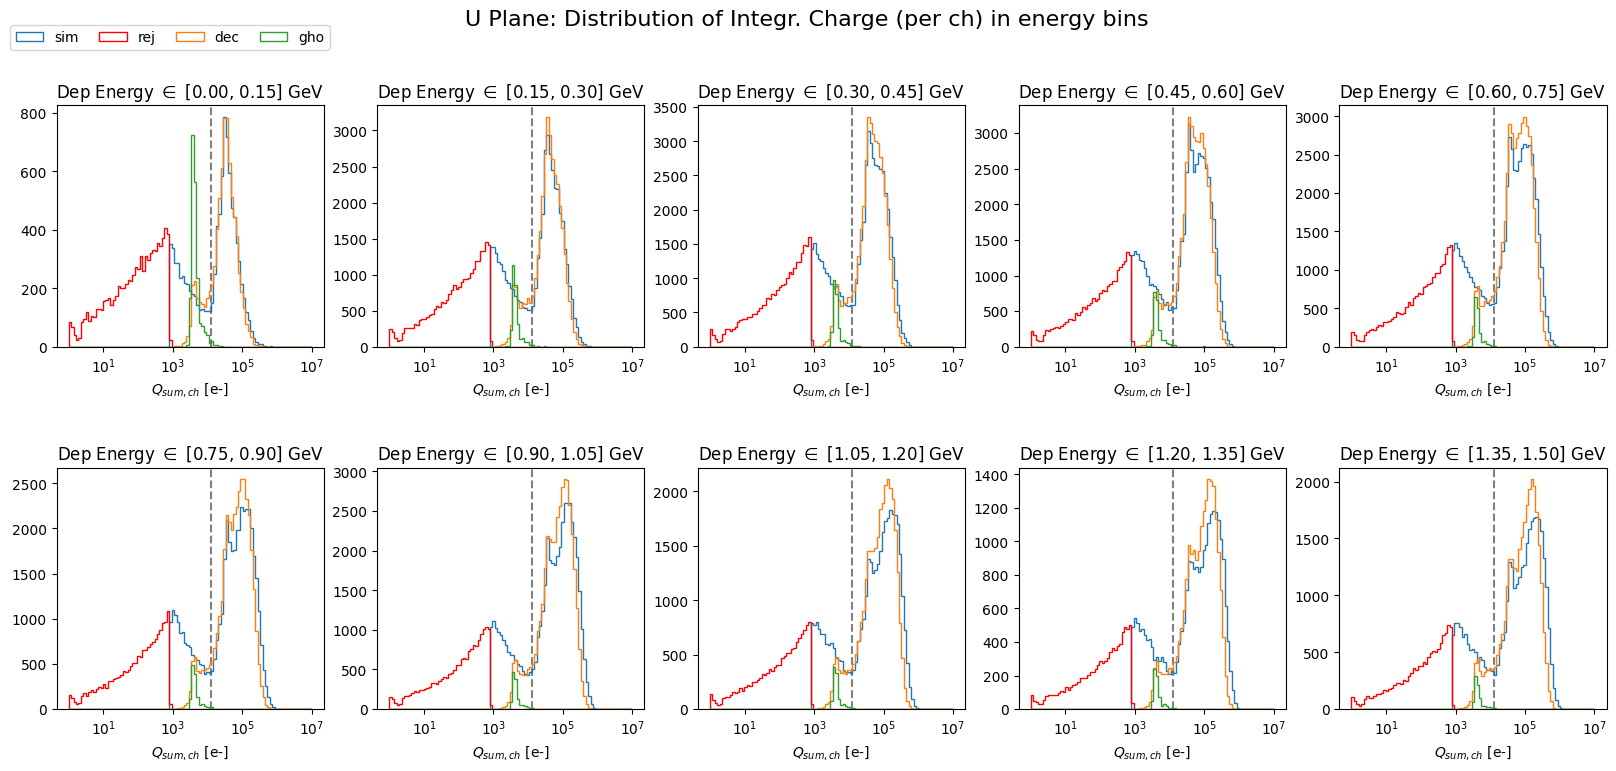

In [42]:
fig, axes = plt.subplots(2,5,figsize=(20,8),sharex=True,dpi=100)
bins = np.logspace(0,7,100)
energy_bins = np.linspace(0,1.5,11)
plt.subplots_adjust(hspace=0.5)

for i, ax in tqdm(enumerate(axes.flatten())):
    lower = energy_bins[i]; upper = energy_bins[i+1]
    mask = (depE_sum_arr>lower) & (depE_sum_arr<upper)
    this_u_sim = np.hstack(u_sim_sum_arr[mask]) if u_sim_sum_arr[mask].size else np.array([]) 
    this_u_rej = np.hstack(u_rej_sum_arr[mask]) if u_rej_sum_arr[mask].size else np.array([])
    this_u_dec = np.hstack(u_dec_sum_arr[mask]) if u_dec_sum_arr[mask].size else np.array([])
    this_u_gho = np.hstack(u_gho_sum_arr[mask]) if u_gho_sum_arr[mask].size else np.array([])
    ax.set_xscale("log")
    ax.tick_params(labelbottom=True)
    ax.hist(this_u_sim,bins=bins,histtype="step",label="sim")
    ax.hist(this_u_rej,bins=bins,histtype="step",label="rej",color="red")
    ax.hist(this_u_dec,bins=bins,histtype="step",label="dec")
    ax.hist(this_u_gho,bins=bins,histtype="step",label="gho")

    ax.set_title(f"Dep Energy $\in$ [{lower:.2f}, {upper:.2f}] GeV")
    if i==0:
        ax.legend(bbox_to_anchor=(-0.2,1.2, 1.25, 1.2), loc="lower left",mode="expand",ncol=4)
    ax.set_xlabel(r"$Q_{sum, ch}$ [e-]")
    ymin, ymax = ax.set_ylim()
    ax.vlines(1.25e4,ymin=ymin,ymax=ymax,linestyles="dashed",colors="gray")
    ax.set_ylim(ymin,ymax)

plt.suptitle("U Plane: Distribution of Integr. Charge (per ch) in energy bins",y=1.0,fontsize=16)
plt.show()

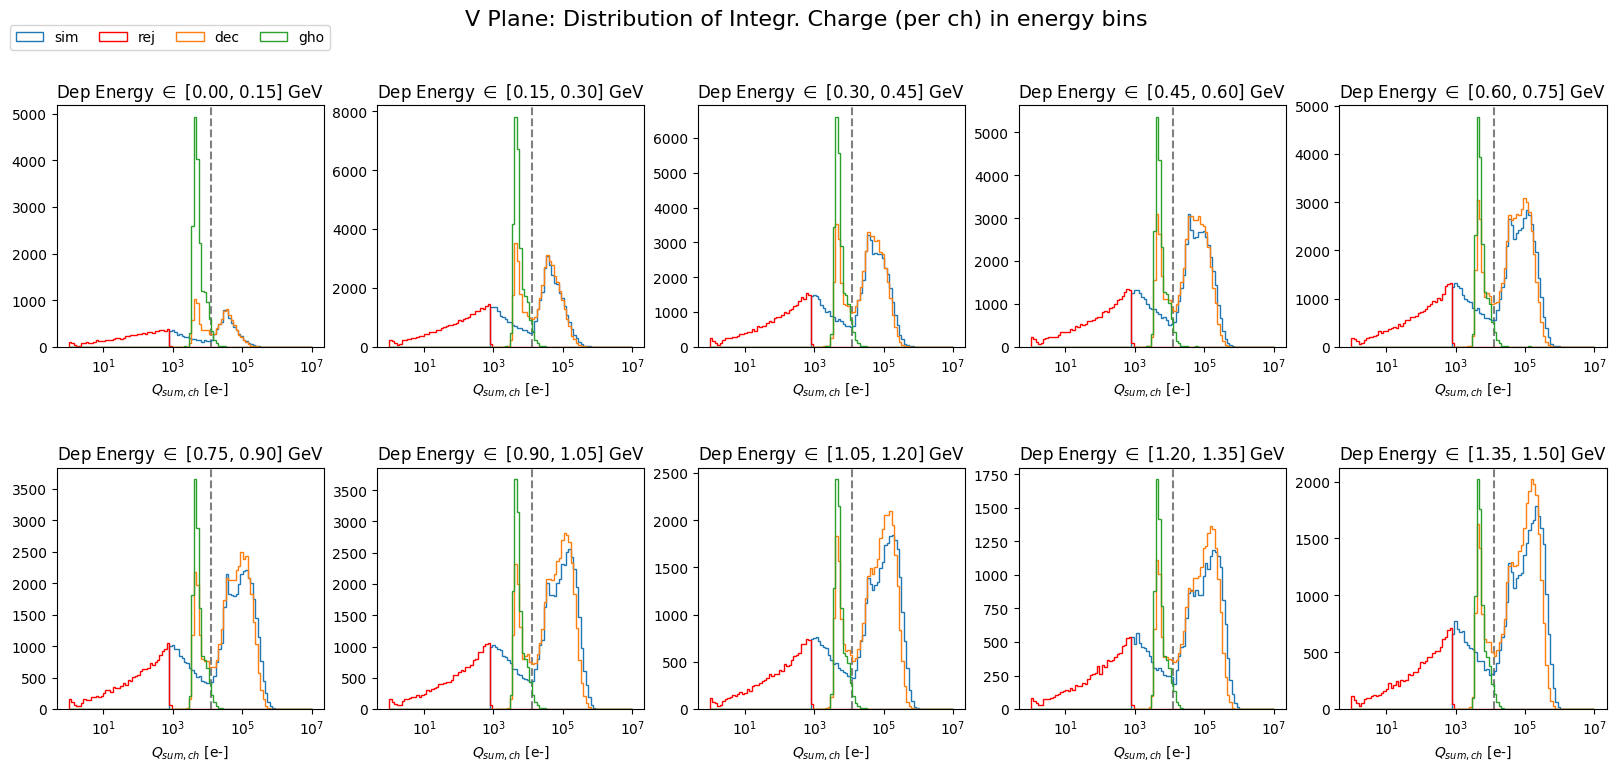

In [41]:
fig, axes = plt.subplots(2,5,figsize=(20,8),sharex=True,dpi=100)
bins = np.logspace(0,7,100)
energy_bins = np.linspace(0,1.5,11)
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flatten()):
    lower = energy_bins[i]; upper = energy_bins[i+1]
    mask = (depE_sum_arr>lower) & (depE_sum_arr<upper)
    this_v_sim = np.hstack(v_sim_sum_arr[mask]) 
    this_v_rej = np.hstack(v_rej_sum_arr[mask])
    this_v_dec = np.hstack(v_dec_sum_arr[mask])
    this_v_gho = np.hstack(v_gho_sum_arr[mask])
    ax.set_xscale("log")
    ax.tick_params(labelbottom=True)
    ax.hist((this_v_sim),bins=bins,histtype="step",label="sim")
    ax.hist((this_v_rej),bins=bins,histtype="step",label="rej",color="red")
    ax.hist((this_v_dec),bins=bins,histtype="step",label="dec")
    ax.hist((this_v_gho),bins=bins,histtype="step",label="gho")

    ax.set_title(f"Dep Energy $\in$ [{lower:.2f}, {upper:.2f}] GeV")
    if i==0:
        ax.legend(bbox_to_anchor=(-0.2,1.2, 1.25, 1.2), loc="lower left",mode="expand",ncol=4)
    ax.set_xlabel(r"$Q_{sum, ch}$ [e-]")
    ymin, ymax = ax.set_ylim()
    ax.vlines(1.25e4,ymin=ymin,ymax=ymax,linestyles="dashed",colors="gray")
    ax.set_ylim(ymin,ymax)

plt.suptitle("V Plane: Distribution of Integr. Charge (per ch) in energy bins",y=1.0,fontsize=16)
plt.show()

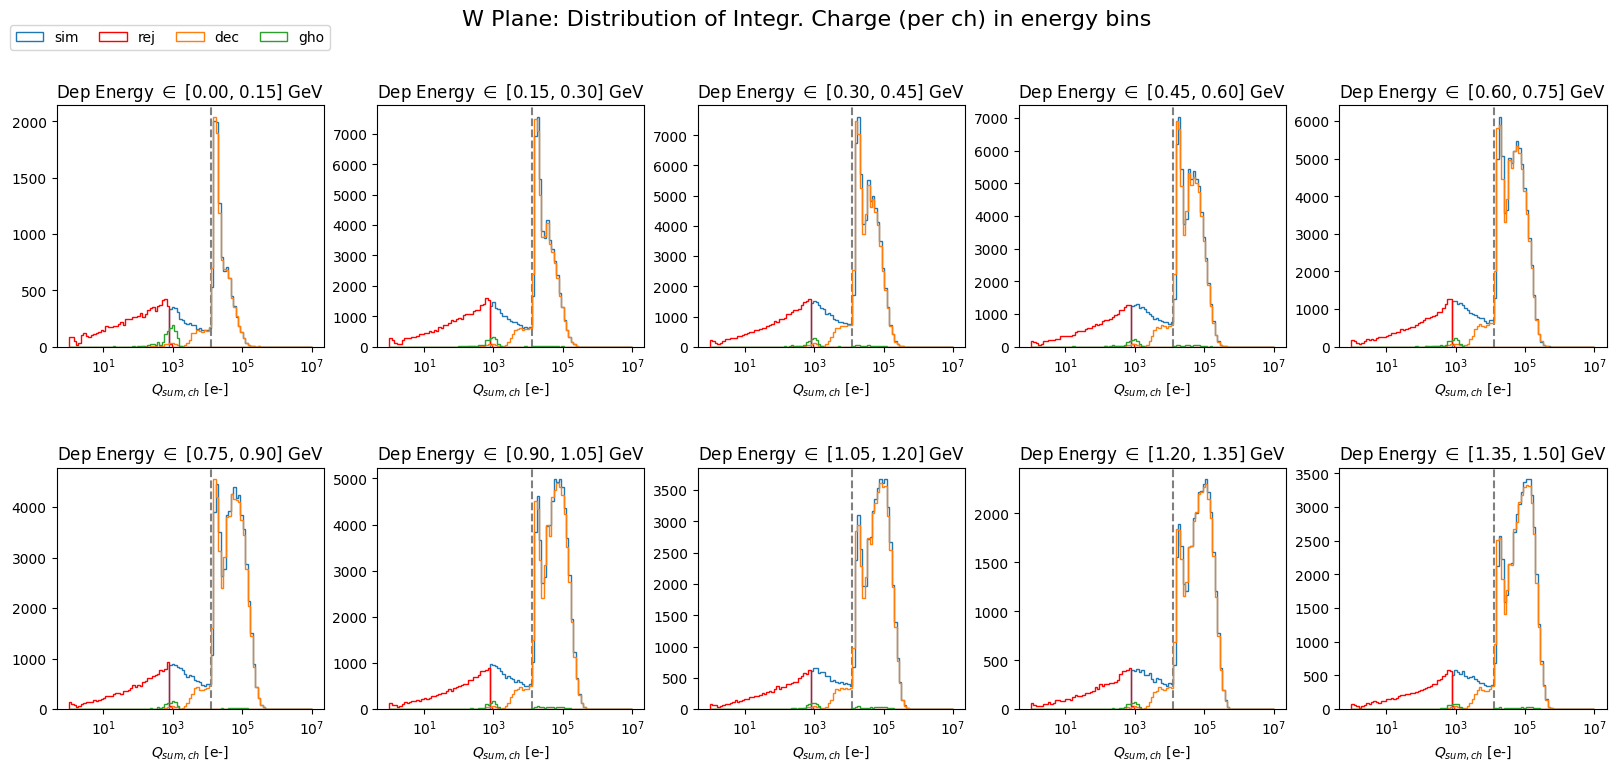

In [40]:
fig, axes = plt.subplots(2,5,figsize=(20,8),sharex=True,dpi=100)
bins = np.logspace(0,7,100)
energy_bins = np.linspace(0,1.5,11)
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flatten()):
    lower = energy_bins[i]; upper = energy_bins[i+1]
    mask = (depE_sum_arr>lower) & (depE_sum_arr<upper)
    this_w_sim = np.hstack(w_sim_sum_arr[mask]) 
    this_w_rej = np.hstack(w_rej_sum_arr[mask])
    this_w_dec = np.hstack(w_dec_sum_arr[mask])
    this_w_gho = np.hstack(w_gho_sum_arr[mask])
    ax.set_xscale("log")
    ax.tick_params(labelbottom=True)
    ax.hist(this_w_sim,bins=bins,histtype="step",label="sim")
    ax.hist(this_w_rej,bins=bins,histtype="step",label="rej",color="red")
    ax.hist(this_w_dec,bins=bins,histtype="step",label="dec")
    ax.hist(this_w_gho,bins=bins,histtype="step",label="gho")

    ax.set_title(f"Dep Energy $\in$ [{lower:.2f}, {upper:.2f}] GeV")
    if i==0:
        ax.legend(bbox_to_anchor=(-0.2,1.2, 1.25, 1.2), loc="lower left",mode="expand",ncol=4)
    ax.set_xlabel(r"$Q_{sum, ch}$ [e-]")
    
    ymin, ymax = ax.set_ylim()
    ax.vlines(1.25e4,ymin=ymin,ymax=ymax,linestyles="dashed",colors="gray")
    ax.set_ylim(ymin,ymax)

plt.suptitle("W Plane: Distribution of Integr. Charge (per ch) in energy bins",y=1.0,fontsize=16)
plt.show()

10it [00:00, 35.11it/s]


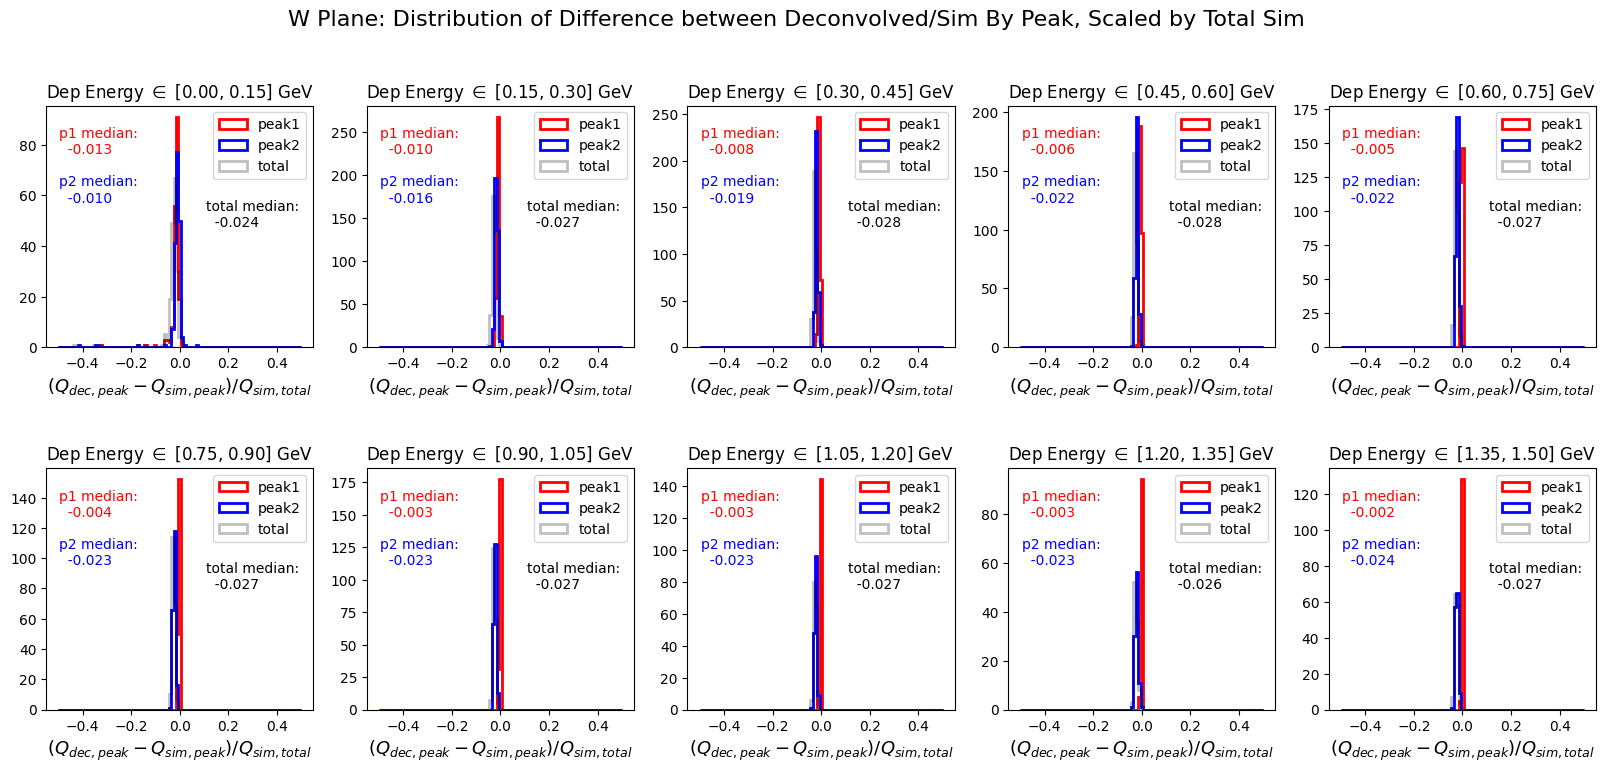

In [47]:
fig, axes = plt.subplots(2,5,figsize=(20,8),sharex=True,dpi=100)
# bins = np.concatenate([-np.logspace(7,0,7),np.logspace(0,7,7)])
bins = np.linspace(-0.5,0.5,100)

energy_bins = np.linspace(0,1.5,11)
plt.subplots_adjust(hspace=0.5)

for i, ax in tqdm(enumerate(axes.flatten())):
    lower = energy_bins[i]; upper = energy_bins[i+1]
    mask = (depE_sum_arr>lower) & (depE_sum_arr<upper)
    this_sim = (w_sim_sum_arr[mask]) 
    this_dec = (w_dec_sum_arr[mask])
    sim_peak2 = np.where(this_sim>=1.25e4,this_sim,0)
    sim_peak1 = np.where(this_sim<1.25e4, this_sim,0)
    dec_peak2 = np.where(this_dec>=1.25e4,this_dec,0)
    dec_peak1 = np.where(this_dec<1.25e4, this_dec,0)

    sim_total = np.sum(this_sim,axis=1)
    dec_total = np.sum(this_dec,axis=1)
    
    ax.tick_params(labelbottom=True)
    #rotate tick labels by 45 degrees
    # ax.xaxis.set_tick_params(rotation=45)
    ax.hist((np.sum(dec_peak1, axis=1) - np.sum(sim_peak1,axis=1))/sim_total
             ,bins=bins,lw=2,histtype="step",label="peak1",color="red")
    ax.hist((np.sum(dec_peak2, axis=1) - np.sum(sim_peak2,axis=1))/sim_total
             ,bins=bins,lw=2,histtype="step",label="peak2",color="blue")    
    ax.hist((dec_total - sim_total)/sim_total
            ,bins=bins,lw=2,histtype="step",label="total",color="black",alpha=0.25)
    
    # ax.hist((np.sum(dec_peak1, axis=1))/(np.sum(sim_peak1,axis=1)),bins=bins,lw=2,histtype="step",label="peak1",color="red")
    # ax.hist((np.sum(dec_peak2, axis=1))/(np.sum(sim_peak2,axis=1)),bins=bins,lw=2,histtype="step",label="peak2",color="blue")    
    
    peak1_diff = (np.sum(dec_peak1, axis=1) - np.sum(sim_peak1,axis=1))/sim_total
    peak2_diff = (np.sum(dec_peak2, axis=1) - np.sum(sim_peak2,axis=1))/sim_total
    
    total_diff = (dec_total - sim_total)/sim_total
    
    # peak1_ratio = (np.sum(dec_peak1, axis=1))/(np.sum(sim_peak1,axis=1))
    # peak2_ratio = (np.sum(dec_peak2, axis=1))/(np.sum(sim_peak2,axis=1))
    
    ax.annotate(f"p1 median: \n  {np.ma.median(np.ma.masked_invalid(peak1_diff)):.3f}",xy=(0.05,0.8),xycoords="axes fraction",fontsize=10,color="red")
    ax.annotate(f"p2 median: \n  {np.ma.median(np.ma.masked_invalid(peak2_diff)):.3f}",xy=(0.05,0.6),xycoords="axes fraction",fontsize=10,color="blue")
    ax.annotate(f"total median: \n  {np.ma.median(np.ma.masked_invalid(total_diff)):.3f}",xy=(0.6,0.5),xycoords="axes fraction",fontsize=10,color="black")
    
    ax.set_title(f"Dep Energy $\in$ [{lower:.2f}, {upper:.2f}] GeV")
    ax.set_xlabel(r"$(Q_{dec,peak} - Q_{sim,peak})/Q_{sim,total}$",fontsize=13)
    ax.legend()

plt.suptitle("W Plane: Distribution of Difference between Deconvolved/Sim By Peak, Scaled by Total Sim",y=1.0,fontsize=16)
plt.show()

10it [00:00, 31.28it/s]


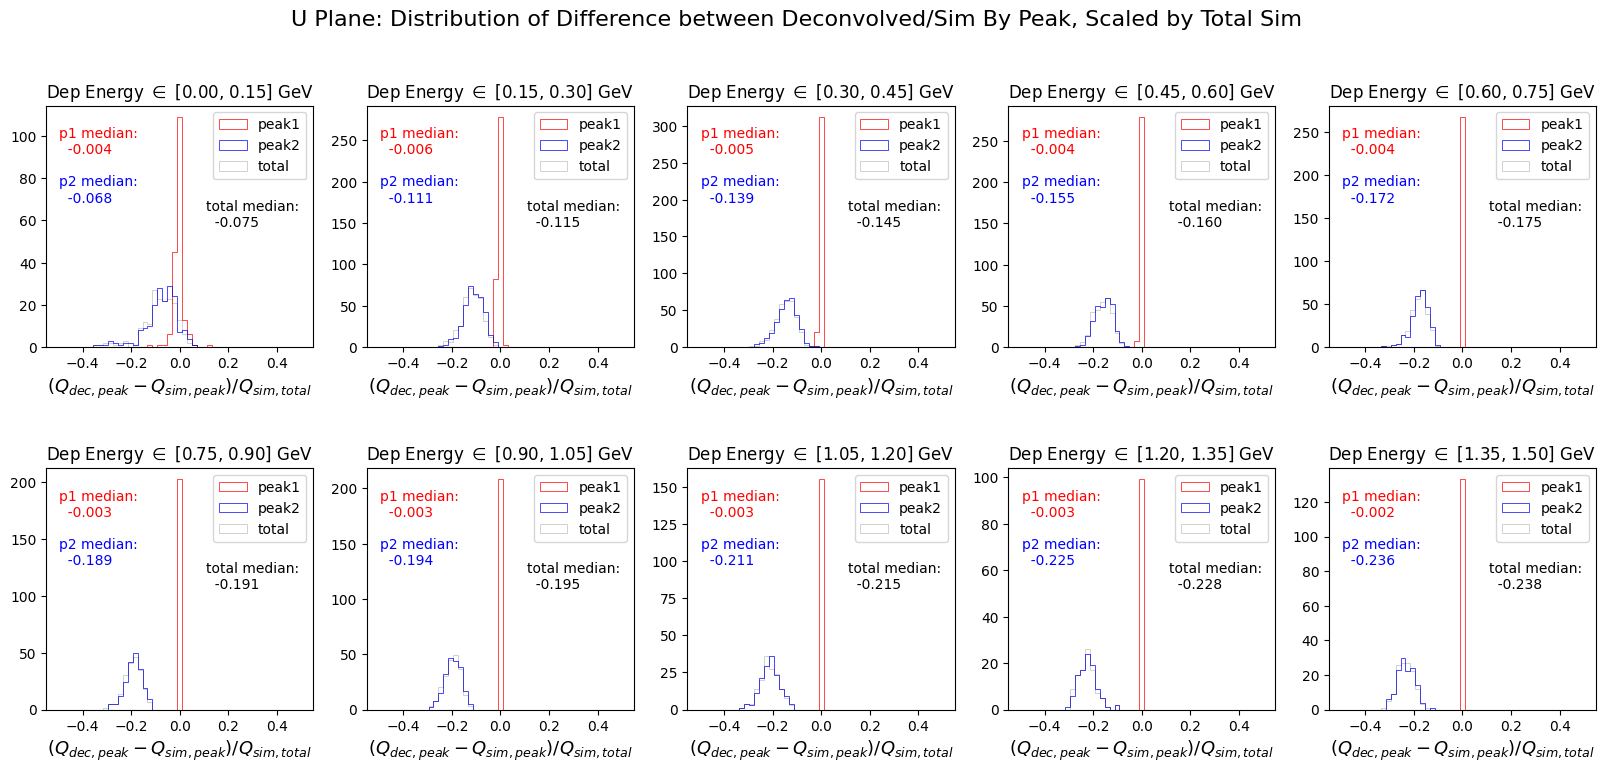

In [49]:
fig, axes = plt.subplots(2,5,figsize=(20,8),sharex=True,dpi=100)
# bins = np.concatenate([-np.logspace(7,0,7),np.logspace(0,7,7)])
bins = np.linspace(-0.5,0.5,50)

energy_bins = np.linspace(0,1.5,11)
plt.subplots_adjust(hspace=0.5)

for i, ax in tqdm(enumerate(axes.flatten())):
    lower = energy_bins[i]; upper = energy_bins[i+1]
    mask = (depE_sum_arr>lower) & (depE_sum_arr<upper)
    this_sim = (u_sim_sum_arr[mask]) 
    this_dec = (u_dec_sum_arr[mask])
    sim_peak2 = np.where(this_sim>=1.25e4,this_sim,0)
    sim_peak1 = np.where(this_sim<1.25e4, this_sim,0)
    dec_peak2 = np.where(this_dec>=1.25e4,this_dec,0)
    dec_peak1 = np.where(this_dec<1.25e4, this_dec,0)

    sim_total = np.sum(this_sim,axis=1)
    dec_total = np.sum(this_dec,axis=1)
    
    ax.tick_params(labelbottom=True)
    #rotate tick labels by 45 degrees
    # ax.xaxis.set_tick_params(rotation=45)
    ax.hist((np.sum(dec_peak1, axis=1) - np.sum(sim_peak1,axis=1))/sim_total
             ,bins=bins,lw=0.5,histtype="step",label="peak1",color="red")
    ax.hist((np.sum(dec_peak2, axis=1) - np.sum(sim_peak2,axis=1))/sim_total
             ,bins=bins,lw=0.5,histtype="step",label="peak2",color="blue")    
    ax.hist((dec_total - sim_total)/sim_total
            ,bins=bins,lw=0.5,histtype="step",label="total",color="black",alpha=0.25)
    
    # ax.hist((np.sum(dec_peak1, axis=1))/(np.sum(sim_peak1,axis=1)),bins=bins,lw=2,histtype="step",label="peak1",color="red")
    # ax.hist((np.sum(dec_peak2, axis=1))/(np.sum(sim_peak2,axis=1)),bins=bins,lw=2,histtype="step",label="peak2",color="blue")    
    
    peak1_diff = (np.sum(dec_peak1, axis=1) - np.sum(sim_peak1,axis=1))/sim_total
    peak2_diff = (np.sum(dec_peak2, axis=1) - np.sum(sim_peak2,axis=1))/sim_total
    
    total_diff = (dec_total - sim_total)/sim_total
    
    # peak1_ratio = (np.sum(dec_peak1, axis=1))/(np.sum(sim_peak1,axis=1))
    # peak2_ratio = (np.sum(dec_peak2, axis=1))/(np.sum(sim_peak2,axis=1))
    
    ax.annotate(f"p1 median: \n  {np.ma.median(np.ma.masked_invalid(peak1_diff)):.3f}",xy=(0.05,0.8),xycoords="axes fraction",fontsize=10,color="red")
    ax.annotate(f"p2 median: \n  {np.ma.median(np.ma.masked_invalid(peak2_diff)):.3f}",xy=(0.05,0.6),xycoords="axes fraction",fontsize=10,color="blue")
    ax.annotate(f"total median: \n  {np.ma.median(np.ma.masked_invalid(total_diff)):.3f}",xy=(0.6,0.5),xycoords="axes fraction",fontsize=10,color="black")
    
    ax.set_title(f"Dep Energy $\in$ [{lower:.2f}, {upper:.2f}] GeV")
    ax.set_xlabel(r"$(Q_{dec,peak} - Q_{sim,peak})/Q_{sim,total}$",fontsize=13)
    ax.legend()

plt.suptitle("U Plane: Distribution of Difference between Deconvolved/Sim By Peak, Scaled by Total Sim",y=1.0,fontsize=16)
plt.show()

10it [00:00, 34.17it/s]


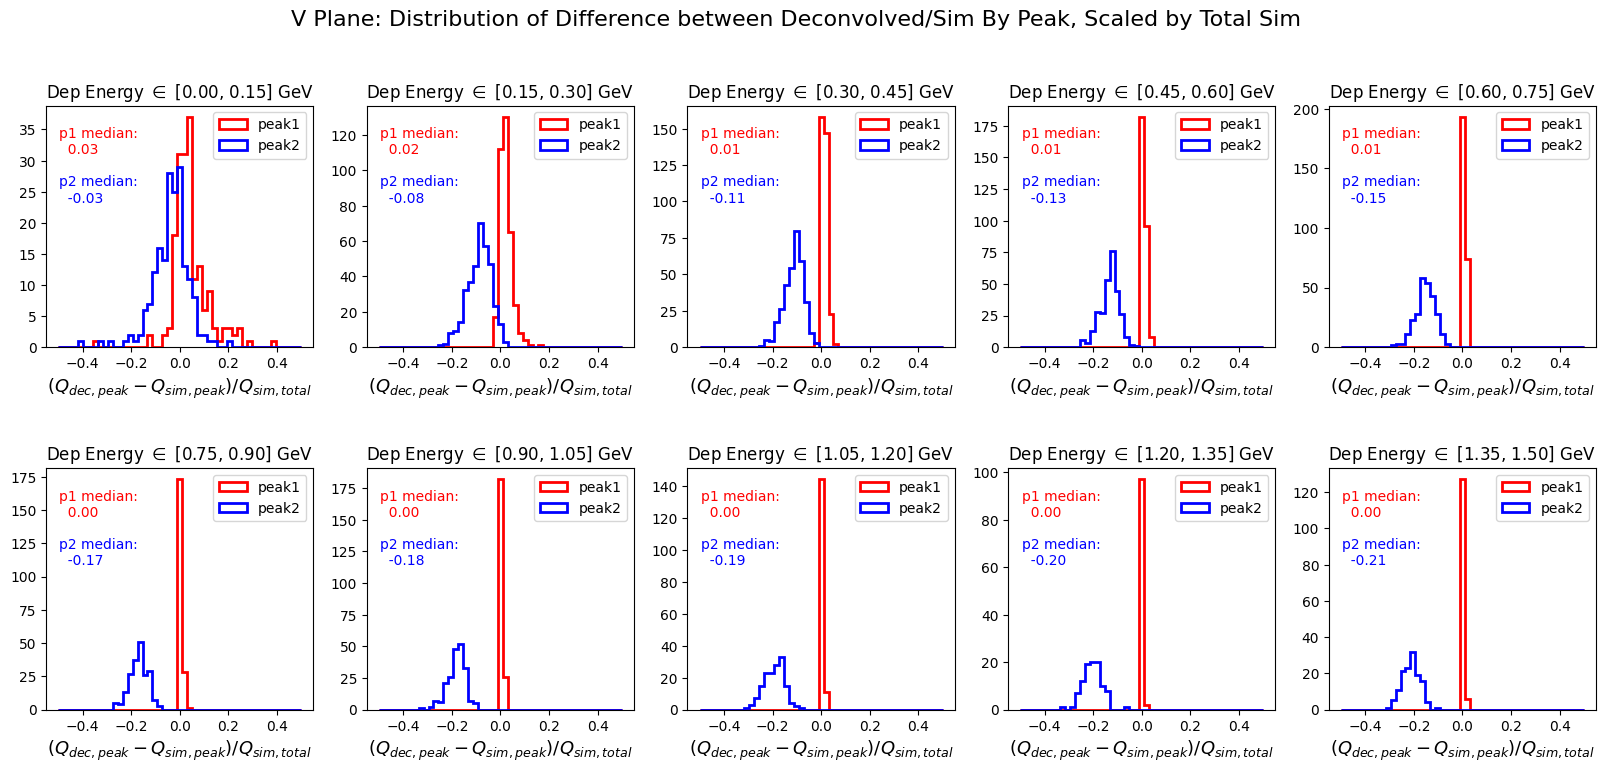

In [31]:
fig, axes = plt.subplots(2,5,figsize=(20,8),sharex=True,dpi=100)
# bins = np.concatenate([-np.logspace(7,0,7),np.logspace(0,7,7)])
bins = np.linspace(-0.5,0.5,50)

energy_bins = np.linspace(0,1.5,11)
plt.subplots_adjust(hspace=0.5)

for i, ax in tqdm(enumerate(axes.flatten())):
    lower = energy_bins[i]; upper = energy_bins[i+1]
    mask = (depE_sum_arr>lower) & (depE_sum_arr<upper)
    this_sim = (v_sim_sum_arr[mask]) 
    this_dec = (v_dec_sum_arr[mask])
    sim_peak2 = np.where(this_sim>=1.25e4,this_sim,0)
    sim_peak1 = np.where(this_sim<1.25e4, this_sim,0)
    dec_peak2 = np.where(this_dec>=1.25e4,this_dec,0)
    dec_peak1 = np.where(this_dec<1.25e4, this_dec,0)

    sim_total = np.sum(this_sim,axis=1)
    dec_total = np.sum(this_dec,axis=1)
    
    ax.tick_params(labelbottom=True)
    #rotate tick labels by 45 degrees
    # ax.xaxis.set_tick_params(rotation=45)
    ax.hist((np.sum(dec_peak1, axis=1) - np.sum(sim_peak1,axis=1))/sim_total
             ,bins=bins,lw=2,histtype="step",label="peak1",color="red")
    ax.hist((np.sum(dec_peak2, axis=1) - np.sum(sim_peak2,axis=1))/sim_total
             ,bins=bins,lw=2,histtype="step",label="peak2",color="blue")    
    
    # ax.hist((np.sum(dec_peak1, axis=1))/(np.sum(sim_peak1,axis=1)),bins=bins,lw=2,histtype="step",label="peak1",color="red")
    # ax.hist((np.sum(dec_peak2, axis=1))/(np.sum(sim_peak2,axis=1)),bins=bins,lw=2,histtype="step",label="peak2",color="blue")    
    
    peak1_diff = (np.sum(dec_peak1, axis=1) - np.sum(sim_peak1,axis=1))/sim_total
    peak2_diff = (np.sum(dec_peak2, axis=1) - np.sum(sim_peak2,axis=1))/sim_total
    
    # peak1_ratio = (np.sum(dec_peak1, axis=1))/(np.sum(sim_peak1,axis=1))
    # peak2_ratio = (np.sum(dec_peak2, axis=1))/(np.sum(sim_peak2,axis=1))
    
    ax.annotate(f"p1 median: \n  {np.ma.median(np.ma.masked_invalid(peak1_diff)):.2f}",xy=(0.05,0.8),xycoords="axes fraction",fontsize=10,color="red")
    ax.annotate(f"p2 median: \n  {np.ma.median(np.ma.masked_invalid(peak2_diff)):.2f}",xy=(0.05,0.6),xycoords="axes fraction",fontsize=10,color="blue")
    
    ax.set_title(f"Dep Energy $\in$ [{lower:.2f}, {upper:.2f}] GeV")
    ax.set_xlabel(r"$(Q_{dec,peak} - Q_{sim,peak})/Q_{sim,total}$",fontsize=13)
    ax.legend()

plt.suptitle("V Plane: Distribution of Difference between Deconvolved/Sim By Peak, Scaled by Total Sim",y=1.0,fontsize=16)
plt.show()

## Event Display

In [206]:
df[(df.depE<1.2) & (df.depE > 0.5)].sort_values(by="file").tail(30)

,file,sub,tpc,u,v,w,u_sim,v_sim,w_sim,u_dec,v_dec,w_dec,theta_xz,depE
9,230.0,186.0,0.0,-0.193610,-0.137667,-0.032728,25522332.0,25526076.0,25518288.0,21382472.0,22437212.0,24709600.0,13.794563,0.990564
4,230.0,186.0,0.0,-0.180190,-0.124679,-0.030339,17693220.0,17691422.0,17688228.0,14991844.0,15730197.0,17167384.0,35.748383,0.702872
7,231.0,187.0,1.0,-0.206290,-0.210288,-0.030110,23407786.0,23411980.0,23414298.0,19404780.0,19344136.0,22729900.0,4.953735,0.896093
17,231.0,187.0,1.0,0.715304,0.688800,0.752446,15237376.0,15232224.0,15238355.0,53521576.0,48946764.0,61555564.0,26.871416,0.602671
15,231.0,187.0,1.0,-0.196265,-0.124434,-0.029857,15240646.0,15246190.0,15257247.0,12740188.0,13558988.0,14814912.0,44.854515,0.703714
10,231.0,187.0,1.0,-0.342653,-0.276481,-0.024349,19813464.0,19807548.0,19820144.0,14756947.0,15517305.0,19349016.0,40.432007,0.847277
11,231.0,187.0,0.0,-0.302920,-0.387874,-0.023894,27917314.0,27913266.0,27918380.0,21426724.0,20112246.0,27266856.0,49.438694,1.098217
3,231.0,187.0,0.0,-0.143486,-0.182707,-0.033122,17156948.0,17161070.0,17170560.0,15004071.0,14509991.0,16620076.0,0.608674,0.815032
19,232.0,188.0,1.0,-0.191927,-0.119517,-0.030058,13844288.0,13846588.0,13835212.0,11615043.0,12368360.0,13431483.0,23.107038,0.544861
5,232.0,188.0,0.0,-0.315258,-0.243358,-0.034961,21272700.0,21266574.0,21270684.0,16173784.0,17104150.0,20552166.0,7.652557,0.858930


### high energy electron event

In [141]:

file_idx = 2

wvfm = uproot.open(wvfm_list[file_idx])
dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

evtnum = 14
sim = wvfm[sim_names[evtnum]].to_numpy()
dec = wvfm[dec_names[evtnum]].to_numpy()
raw = wvfm[raw_names[evtnum]].to_numpy()
tpc = 1
evt_df = df[(df.file == file_idx)].loc[[evtnum]]
evt_df = evt_df[evt_df.tpc==0]
col_angle = round(evt_df.theta_xz.values[0],2)
ind_angle = prime_angle(col_angle)
energy = round(evt_df.depE.values[0],2)

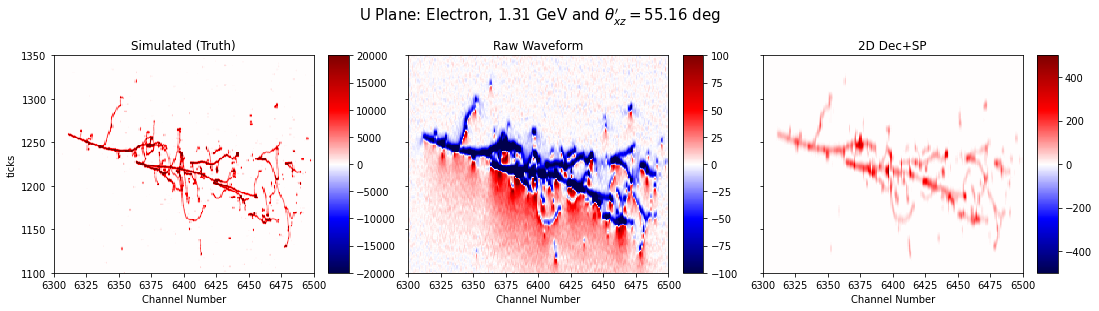

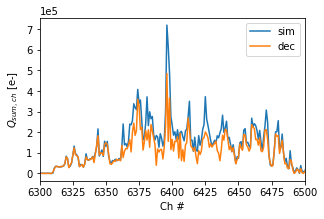

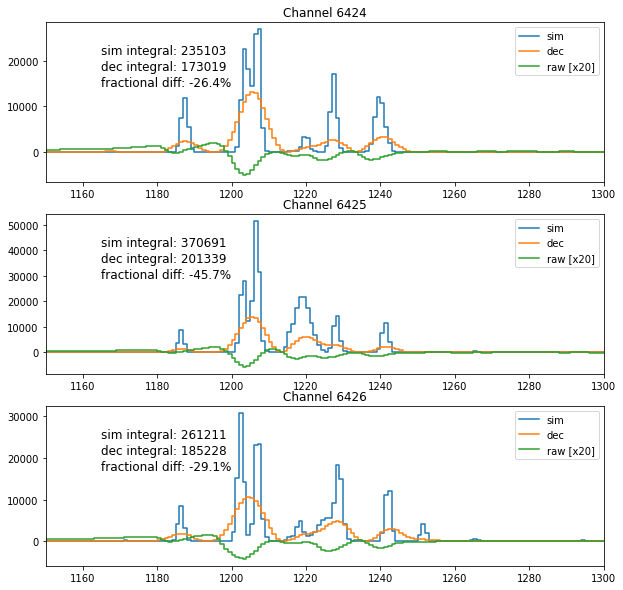

In [146]:

ch_min = 6300; ch_max = 6500
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=1100,ymax=1350,title=fr"U Plane: Electron, {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

plot_wvfms(chnum=6425,wvfm=wvfm,raw_names=raw_names,sim_names=sim_names,dec_names=dec_names,evtnum=evtnum,range=[1150,1300],textxcoord=0.1)

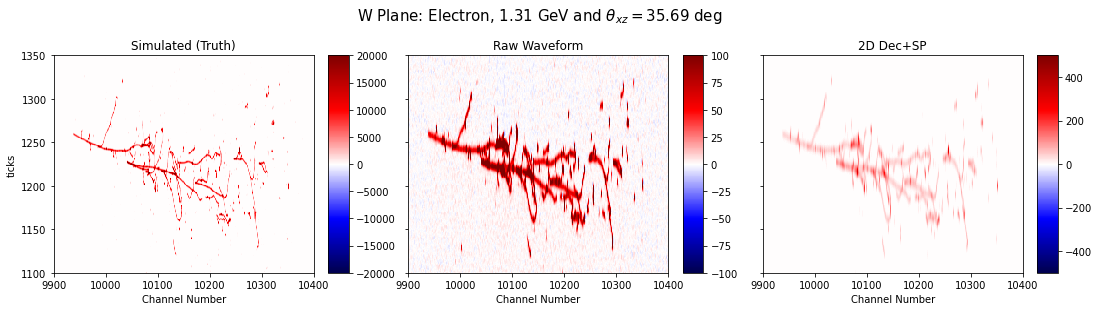

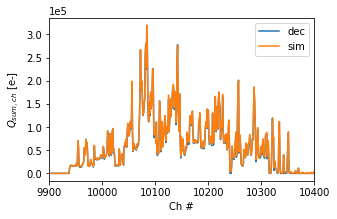

In [140]:
ch_min = 9900; ch_max = 10400
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=1100,ymax=1350,title=fr"W Plane: Electron, {energy} GeV and $\theta_{{xz}} = ${col_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_w1,11264),(np.sum(w1_ch(dec[0])*50,axis=1)),label="dec")
plt.plot(np.arange(idx_w1,11264),(np.sum(w1_ch(sim[0]),axis=1))   ,label="sim")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

In [189]:
file_idx = 3
evtnum = 0
tpc = 1

wvfm = uproot.open(wvfm_list[file_idx])
dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

sim = wvfm[sim_names[evtnum]].to_numpy()
dec = wvfm[dec_names[evtnum]].to_numpy()
raw = wvfm[raw_names[evtnum]].to_numpy()
evt_df = df[(df.file == file_idx)].loc[[evtnum]]
evt_df = evt_df[evt_df.tpc==tpc]
col_angle = round(evt_df.theta_xz.values[0],2)
ind_angle = prime_angle(col_angle)
energy = round(evt_df.depE.values[0],2)

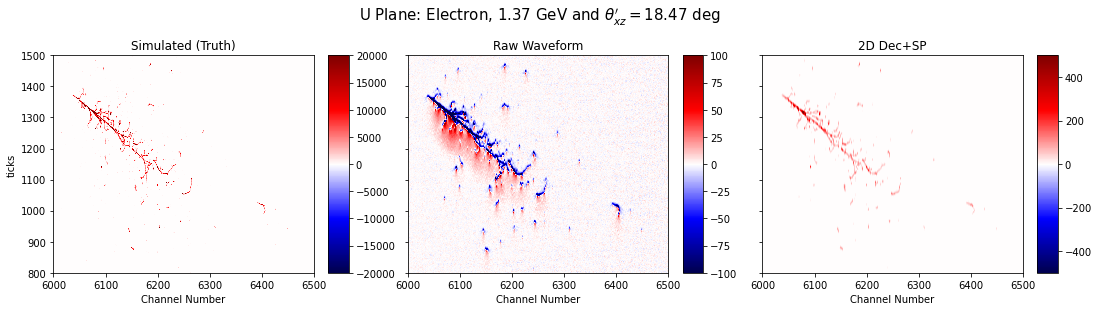

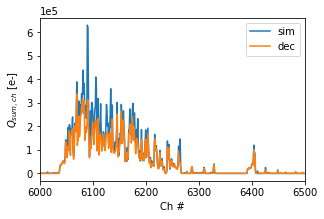

In [149]:
ch_min = 6000; ch_max = 6500
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=800,ymax=1500,title=fr"U Plane: Electron, {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

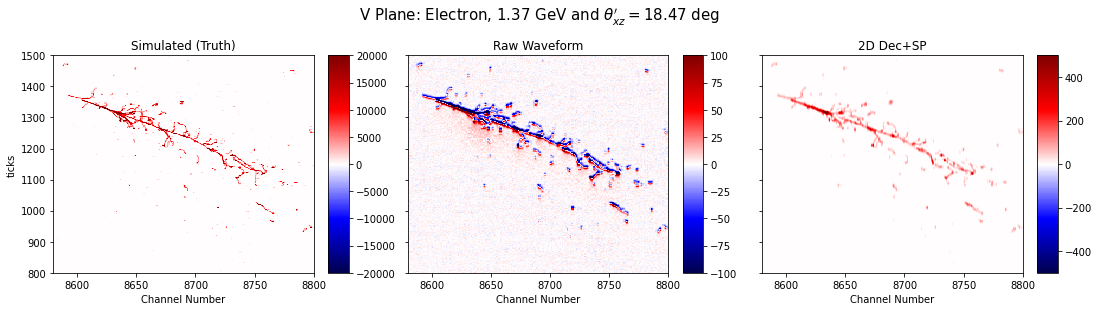

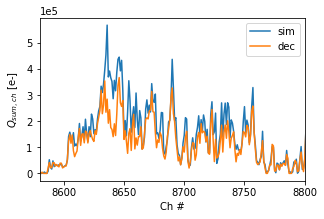

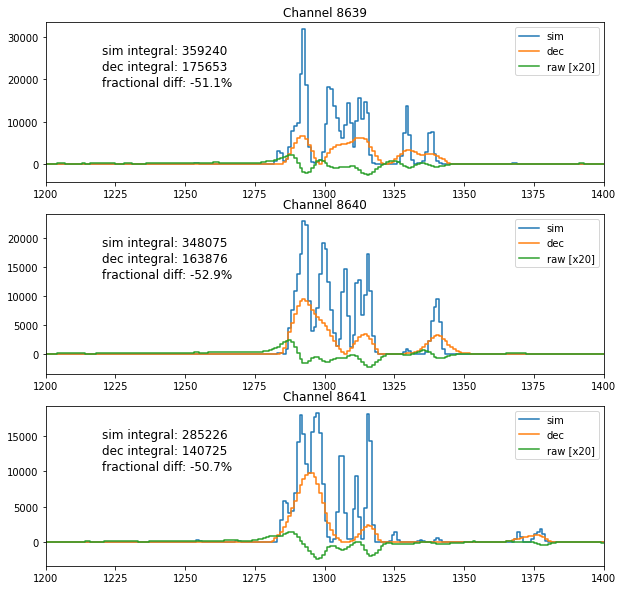

In [158]:
ch_min = 8580; ch_max = 8800
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=800,ymax=1500,title=fr"V Plane: Electron, {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_v1,idx_w1),(np.sum(v1_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_v1,idx_w1),(np.sum(v1_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

plot_wvfms(chnum=8640,wvfm=wvfm,raw_names=raw_names,sim_names=sim_names,dec_names=dec_names,evtnum=evtnum,range=[1200,1400],textxcoord=0.1)

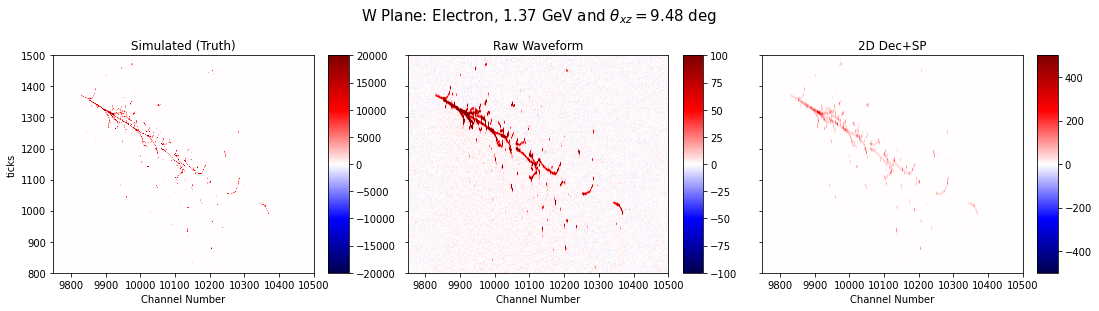

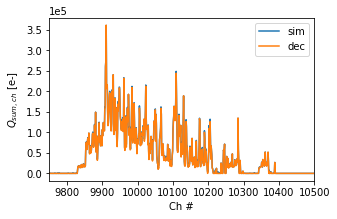

In [137]:
ch_min = 9750; ch_max = 10500
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=800,ymax=1500,title=fr"W Plane: Electron, {energy} GeV and $\theta_{{xz}} = ${col_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_w1,11264),(np.sum(w1_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_w1,11264),(np.sum(w1_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

### low energy electron event

In [180]:
df[df.depE < 0.5]

,file,sub,tpc,u,v,w,u_sim,v_sim,w_sim,u_dec,v_dec,w_dec,theta_xz,depE
1,223.0,106.0,0.0,-0.126846,-0.149311,-0.027654,6.486206e+06,6.484201e+06,6.482723e+06,5756070.0,5641817.0,6308271.0,22.026825,0.249628
6,223.0,106.0,0.0,-0.142461,0.051993,-0.010359,2.014258e+06,2.013238e+06,2.012189e+06,1763087.0,2123654.0,1991558.0,48.797501,0.076581
19,223.0,106.0,0.0,-0.052483,0.003765,-0.029347,4.789930e+06,4.795196e+06,4.793270e+06,4551077.0,4813320.0,4656613.0,14.214361,0.181891
0,223.0,106.0,1.0,-0.188692,-0.120678,-0.027717,1.188899e+07,1.188524e+07,1.188168e+07,10001745.0,10605398.0,11561228.0,9.068221,0.457878
3,223.0,106.0,1.0,-0.111920,-0.106988,-0.031803,1.030452e+07,1.030406e+07,1.030592e+07,9267316.0,9308194.0,9988262.0,9.485289,0.412121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,1.0,20.0,0.0,-0.143708,-0.220362,-0.032189,7.500256e+06,7.500182e+06,7.507843e+06,6557839.0,6145866.0,7273710.0,27.464613,0.301255
1,1.0,20.0,1.0,-0.297677,0.072716,-0.014278,3.324713e+06,3.329544e+06,3.325760e+06,2562049.0,3590642.0,3278942.0,45.497707,0.148678
6,1.0,20.0,1.0,-0.099993,0.034166,-0.039716,2.664730e+06,2.659561e+06,2.657184e+06,2422497.0,2753643.0,2555683.0,2.425018,0.107301
8,1.0,20.0,1.0,-0.228061,-0.211208,-0.024061,5.780478e+06,5.788533e+06,5.780038e+06,4706994.0,4779139.0,5644233.0,40.025669,0.226070


In [183]:
file_idx = 223
evtnum = 1
tpc = 0

wvfm = uproot.open(wvfm_list[file_idx])
dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

sim = wvfm[sim_names[evtnum]].to_numpy()
dec = wvfm[dec_names[evtnum]].to_numpy()
raw = wvfm[raw_names[evtnum]].to_numpy()
evt_df = df[(df.file == file_idx)].loc[[evtnum]]
evt_df = evt_df[evt_df.tpc==0]
col_angle = round(evt_df.theta_xz.values[0],2)
ind_angle = prime_angle(col_angle)
energy = round(evt_df.depE.values[0],2)

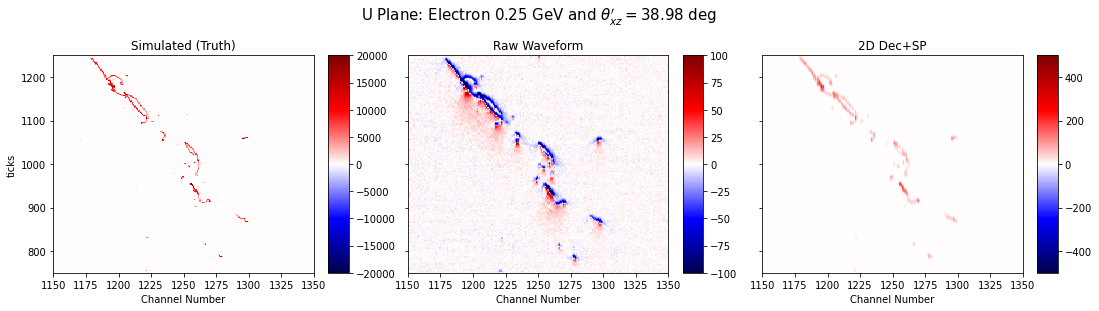

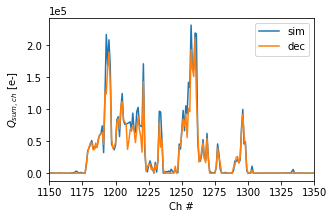

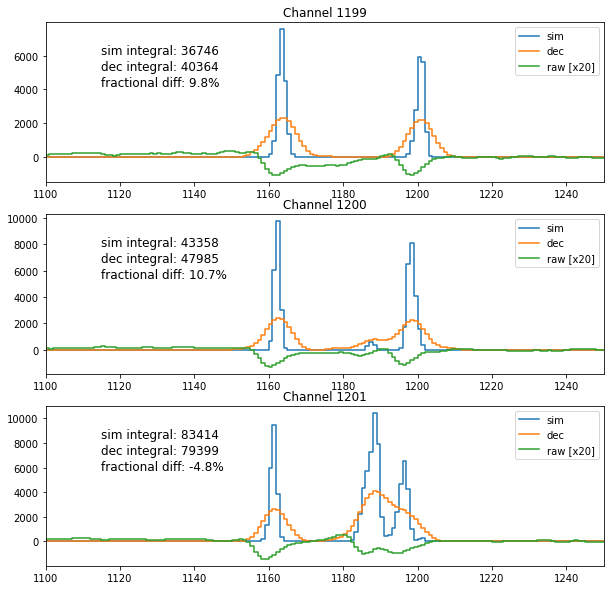

In [188]:
ch_min = 1150; ch_max = 1350
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=750,ymax=1250,title=rf"U Plane: Electron {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")
plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_u0,idx_v0),(np.sum(u0_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_u0,idx_v0),(np.sum(u0_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

plot_wvfms(chnum=1200,wvfm=wvfm,raw_names=raw_names,sim_names=sim_names,dec_names=dec_names,evtnum=evtnum,range=[1100,1250],textxcoord=0.1)

### mid energy event

In [161]:
file_idx = 234

wvfm = uproot.open(wvfm_list[file_idx])
dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

evtnum = 11
tpc = 1
sim = wvfm[sim_names[evtnum]].to_numpy()
dec = wvfm[dec_names[evtnum]].to_numpy()
raw = wvfm[raw_names[evtnum]].to_numpy()

evt_df = df[(df.file == file_idx)].loc[[evtnum]]
evt_df = evt_df[evt_df.tpc==tpc]
col_angle = round(evt_df.theta_xz.values[0],2)
ind_angle = prime_angle(col_angle)
energy = round(evt_df.depE.values[0],2)

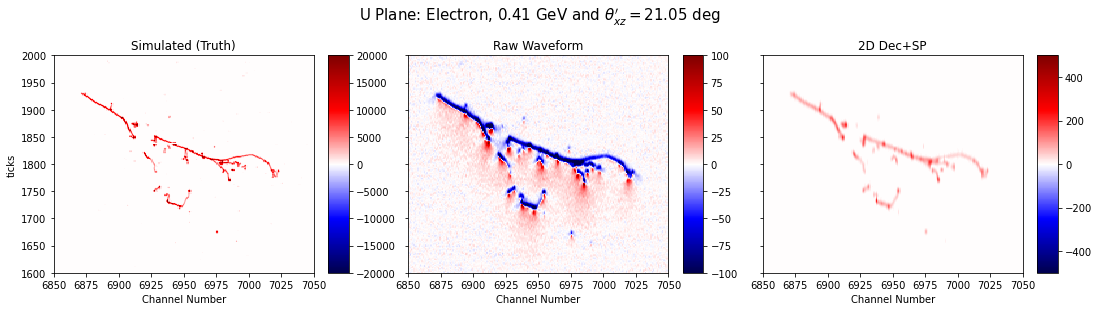

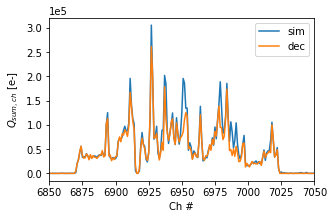

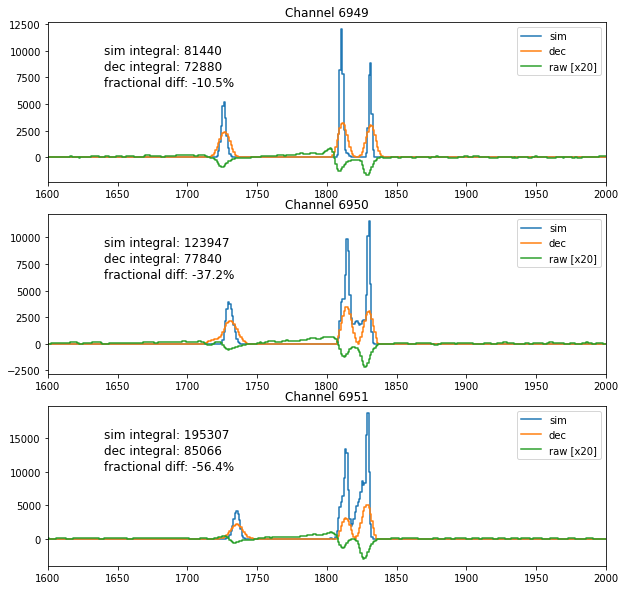

In [171]:
ch_min = 6850; ch_max = 7050
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=1600,ymax=2000,title=fr"U Plane: Electron, {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

plot_wvfms(chnum=6950,wvfm=wvfm,raw_names=raw_names,sim_names=sim_names,dec_names=dec_names,evtnum=evtnum,range=[1600,2000],textxcoord=0.1)

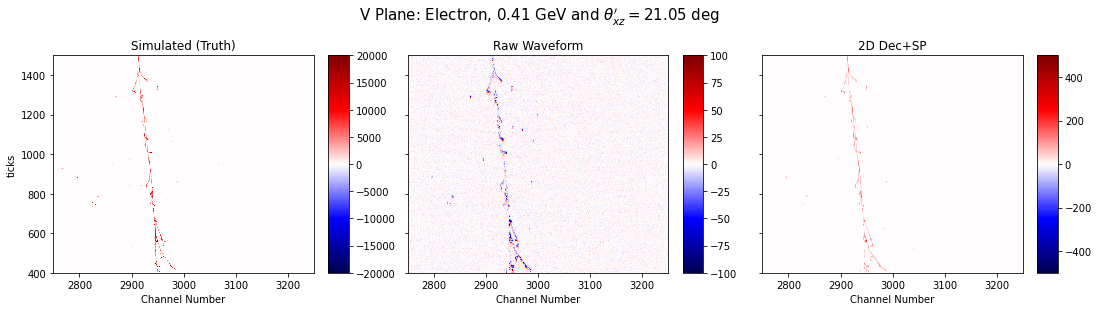

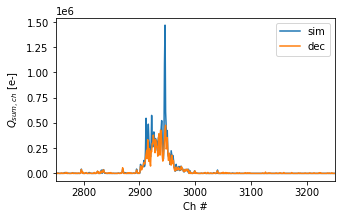

In [163]:
ch_min = 2750; ch_max = 3250
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=400,ymax=1500,title=fr"V Plane: Electron, {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")

plt.figure(figsize=(5,3))
plt.plot(np.arange(idx_v0,idx_w0),(np.sum(v0_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_v0,idx_w0),(np.sum(v0_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

In [191]:
file_idx = 234

wvfm = uproot.open(wvfm_list[file_idx])
dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

evtnum = 15
tpc = 1
sim = wvfm[sim_names[evtnum]].to_numpy()
dec = wvfm[dec_names[evtnum]].to_numpy()
raw = wvfm[raw_names[evtnum]].to_numpy()

evt_df = df[(df.file == file_idx)].loc[[evtnum]]
evt_df = evt_df[evt_df.tpc==tpc]
col_angle = round(evt_df.theta_xz.values[0],2)
ind_angle = prime_angle(col_angle)
energy = round(evt_df.depE.values[0],2)

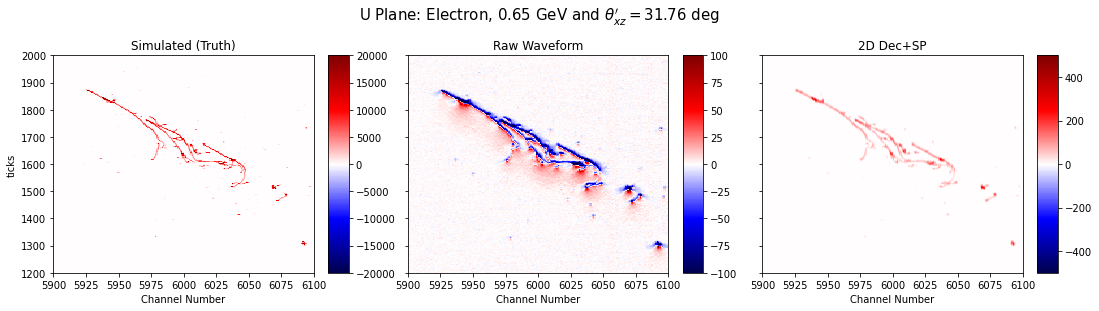

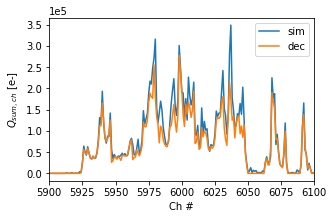

In [198]:
ch_min = 5900; ch_max = 6100
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=1200,ymax=2000,title=fr"U Plane: Electron, {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

# plot_wvfms(chnum=6950,wvfm=wvfm,raw_names=raw_names,sim_names=sim_names,dec_names=dec_names,evtnum=evtnum,range=[1600,2000],textxcoord=0.1)

In [199]:
file_idx = 234

wvfm = uproot.open(wvfm_list[file_idx])
dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

evtnum = 14
tpc = 1
sim = wvfm[sim_names[evtnum]].to_numpy()
dec = wvfm[dec_names[evtnum]].to_numpy()
raw = wvfm[raw_names[evtnum]].to_numpy()

evt_df = df[(df.file == file_idx)].loc[[evtnum]]
evt_df = evt_df[evt_df.tpc==tpc]
col_angle = round(evt_df.theta_xz.values[0],2)
ind_angle = prime_angle(col_angle)
energy = round(evt_df.depE.values[0],2)

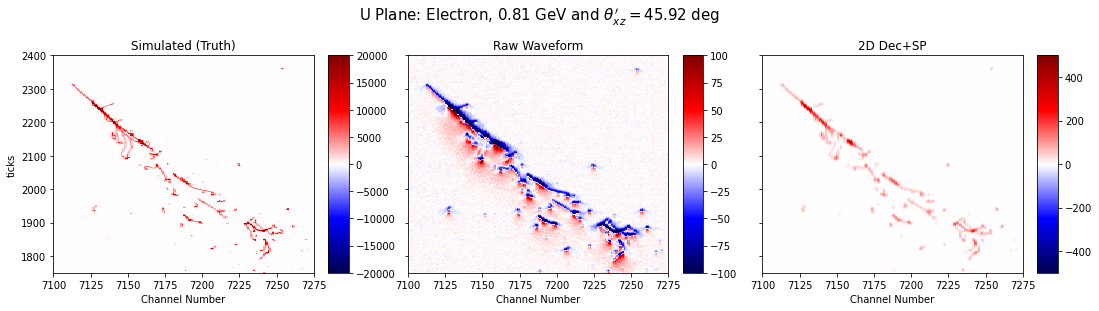

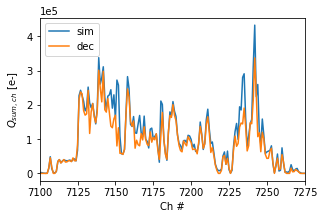

In [205]:
ch_min = 7100; ch_max = 7275
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=1750,ymax=2400,title=fr"U Plane: Electron, {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

# plot_wvfms(chnum=6950,wvfm=wvfm,raw_names=raw_names,sim_names=sim_names,dec_names=dec_names,evtnum=evtnum,range=[1600,2000],textxcoord=0.1)

In [209]:
file_idx = 232

wvfm = uproot.open(wvfm_list[file_idx])
dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

evtnum = 5
tpc = 0
sim = wvfm[sim_names[evtnum]].to_numpy()
dec = wvfm[dec_names[evtnum]].to_numpy()
raw = wvfm[raw_names[evtnum]].to_numpy()

evt_df = df[(df.file == file_idx)].loc[[evtnum]]
evt_df = evt_df[evt_df.tpc==tpc]
col_angle = round(evt_df.theta_xz.values[0],2)
ind_angle = prime_angle(col_angle)
energy = round(evt_df.depE.values[0],2)

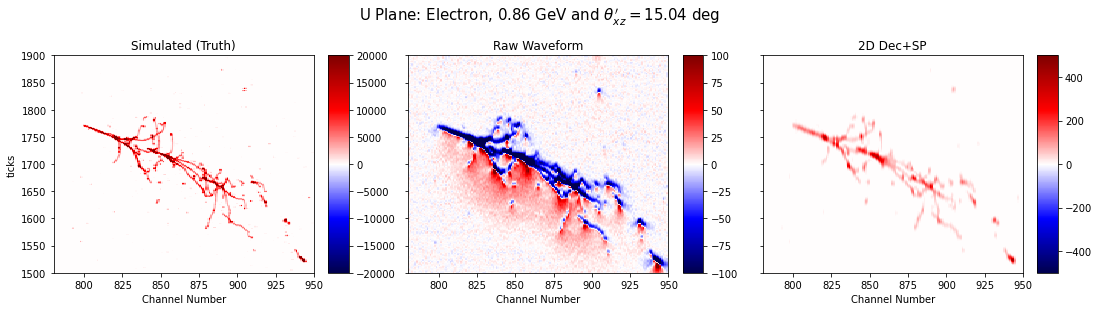

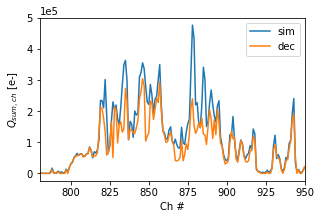

In [213]:
ch_min = 780; ch_max = 950
# ch_min = 7100; ch_max = 7275
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=1500,ymax=1900,title=fr"U Plane: Electron, {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_u0,idx_v0),(np.sum(u0_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_u0,idx_v0),(np.sum(u0_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

# plot_wvfms(chnum=6950,wvfm=wvfm,raw_names=raw_names,sim_names=sim_names,dec_names=dec_names,evtnum=evtnum,range=[1600,2000],textxcoord=0.1)

In [217]:
file_idx = 232

wvfm = uproot.open(wvfm_list[file_idx])
dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

evtnum = 13
tpc = 1
sim = wvfm[sim_names[evtnum]].to_numpy()
dec = wvfm[dec_names[evtnum]].to_numpy()
raw = wvfm[raw_names[evtnum]].to_numpy()

evt_df = df[(df.file == file_idx)].loc[[evtnum]]
evt_df = evt_df[evt_df.tpc==tpc]
col_angle = round(evt_df.theta_xz.values[0],2)
ind_angle = prime_angle(col_angle)
energy = round(evt_df.depE.values[0],2)

In [246]:
caf = uproot.open(caf_list[file_idx]+":recTree")
tree = caf.arrays(["rec.hdr.evt","rec.true_particles.parent","rec.true_particles.pdg","rec.true_particles.genE","rec.true_particles.start.x"],library='pd')
tree["tpc"] = np.where(tree["rec.true_particles.start.x"] < 0, 0, 1)
tree[(tree["rec.hdr.evt"]==evtnum+1) & (tree["tpc"]==tpc)]

,,rec.hdr.evt,rec.true_particles.parent,rec.true_particles.pdg,rec.true_particles.genE,rec.true_particles.start.x,tpc
entry,subentry,,,,,,
13,0,14,0,11,0.768253,102.756721,1


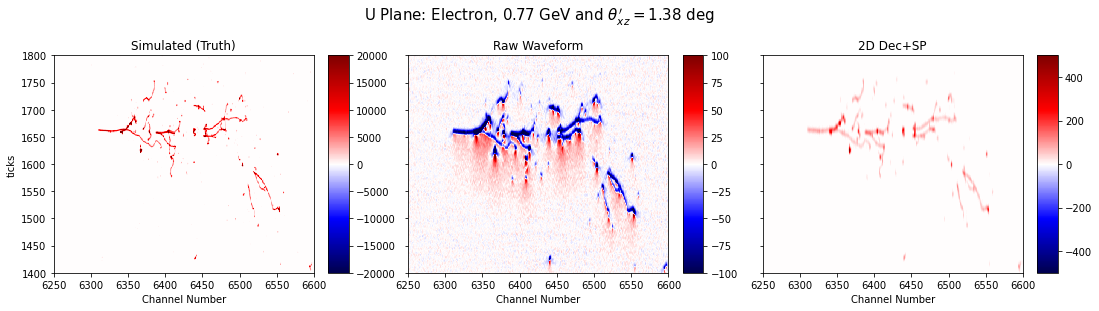

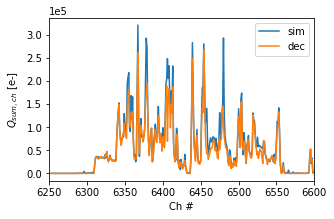

In [219]:
ch_min = 6250; ch_max = 6600
# ch_min = idx_u1; ch_max = idx_v1
plot_evt(ch_min,ch_max,sim,raw,dec,ymin=1400,ymax=1800,title=fr"U Plane: Electron, {energy} GeV and $\theta_{{xz}}' = ${ind_angle} deg")

plt.figure(figsize=(4.75,3))
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(sim[0]),axis=1))   ,label="sim")
plt.plot(np.arange(idx_u1,idx_v1),(np.sum(u1_ch(dec[0])*50,axis=1)),label="dec")
plt.xlim(ch_min,ch_max)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.ylabel(r"$Q_{sum,ch}$ [e-]")
plt.xlabel("Ch #")
plt.legend()
plt.show()

# plot_wvfms(chnum=6950,wvfm=wvfm,raw_names=raw_names,sim_names=sim_names,dec_names=dec_names,evtnum=evtnum,range=[1600,2000],textxcoord=0.1)